# MA6202: Laboratorio de Ciencia de Datos

**Profesor: Nicolás Caro**\
**Auxiliar: Rodrigo Lara M**

**17/05/2020 - Tarea 1**


**Integrantes del grupo**: Pablo Araya Z., Fabian Badilla M.

## 1 Introducción
La siguiente evaluación corresponde a la primera tarea del curso de laboratorio de ciencia de datos. A modo de contexto, se trabajará con un conjunto de datos, en el cual se busca una estimación del precio por metro cuadrado para viviendas en la ciudad de Bogotá, se busca además de una estimación de incertidumbre en predicción.\
Para ello, se proporcionan datos recolectados por _web-scrapping_ y una serie de estadísticas que caracterizan determinadas zonas geográficas de interés, llamadas Unidades de Planeación Zonal (UPZ).

Las condiciones de entrega requeridas son:

* La extensión máxima de el informe es de 6 planas a las que puede añadir 2 para demostraciones.
* Debe adjuntar un repositorio `git` donde se incluya todo su código.
* A lo menos 1 `commit` por cada pregunta de la tarea
* Por lo menos 1 `merge` a través de su trabajo.
* Incluya un documento `jupyter notebook` llamado `tarea1.ipynb` en el cual se exponga todo el procedimiento realizado.
* Por último es necesario también entregar un archivo _pickle_ denominado `modelo.pk` que contenga el último modelo de regresión entrenado.

Tenga en mente que su informe será revisado por un equipo técnico que debe entender a cabalidad su metodología, ser capaz de replicarlo y evaluarlo a partir de la lectura de este.

## Imports

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, sys
import warnings
from IPython.display import clear_output,display_html
import missingno as msno
from sklearn.base import RegressorMixin, BaseEstimator

warnings.filterwarnings('ignore')

## P1. Carga y limpieza de datos
En la presente sección se realizan los pasos de carga y limpieza de datos que permitirán realizar las secciones
posteriores con un `DataFrame` consolidado que presente los tipos de datos adecuados para la información contenida
en sus columnas.\
Incluya en el reporte todas las decisiones que llevó en esta seccion, ademas de reportar y discutir acerca de
los aspectos específicos señalados en cada pregunta.

1. Los datos recolectados en la carpeta `data/raw` están divididos en carpetas con el formato `wNN` donde `NN` corresponde a la semana del año en la que estos fueron consultados. Cargue los datos en un solo `DataFrame` y elimine las filas duplicadas. Además genere una variable categórica en la que se indique si la observación correspondiente proviene de un archivo que en su nombre contiene `'furnished'`\
(ejemplo: metrocuadrado_furnished_wNN.csv).\
**Hint:** para lo último puede ser útil estudiar los argumentos del
método `pd.merge`. Reporte si existen observaciones de archivos con texto `'furnished'` que no estén contenidos en archivos con texto `'all'`.

In [2]:
''' Se juntan los dfs de los csv con nombre "all" '''
df_s = []
for i in range(13,18):
    w = "w"+str(i)
    direccion = 'data/raw/'+w+'/metrocuadrado_all_'+w+'.csv'
    df = pd.read_csv(direccion)
    df_s.append(df)
df_all = pd.concat(df_s,axis=0,ignore_index = True)

'''Creamos la variable categorica'''
df_all['Archivo'] = 'all'

''' Eliminamos los datos duplicados'''
df_all.drop_duplicates(inplace=True,ignore_index=True)

''' Se juntan los dfs de los csv con nombre "furnished" '''
df_s = []
for i in range(13,18):
    w = "w"+str(i)
    direccion = 'data/raw/'+w+'/metrocuadrado_furnished_'+w+'.csv'
    df = pd.read_csv(direccion)
    df_s.append(df)
df_fur = pd.concat(df_s,axis=0,ignore_index = True)

'''Creamos la variable categorica'''
df_fur['Archivo'] = 'furnished'

''' Eliminamos los datos duplicados'''
df_fur.drop_duplicates(inplace=True,ignore_index=True)

''' Juntamos los dos dfs'''
df = pd.concat([df_all,df_fur],axis=0,ignore_index = True)

''' Eliminamos posibles datos de furnished que esten en all'''
df.drop_duplicates(['property_type|rent_type|location', 'price', 'n_rooms', 'n_bath','surface', 'details',
                    'url', 'metrocuadrado_index'],inplace=True,ignore_index=True)

print('Hay',sum(df['Archivo']=='furnished'),'Observaciones de furnished que no estan contenidas en all')

Hay 2099 Observaciones de furnished que no estan contenidas en all


2. Limpie las columnas:
    1. Precio y de área del inmueble, número de habitaciones y número de baños.
    2. De `'property type|rent type|location'`. Debe obtener 3 columnas en las que se detalle el tipo de inmueble (casa o apartamento), el tipo de la oferta (arriendo o arriendo y venta) además de el barrio en el cual se ubica el inmueble (texto en mayúsculas para la mayoría de los casos) Llame a esta última columna `'location'`.\
    __Hint:__ Para ello pueden ser útiles los métodos `str.split` y `str.strip` de la clase `pd.Series`.

In [3]:
''' Quitamos los nan '''
df = df.dropna(axis = 0)#,subset=['price','n_rooms','n_bath','surface'])
df.reset_index(drop=True,inplace=True)

''' Limpiamos los datos de price y surface '''
df['price'] = [x.replace('$','') for x in df['price']]
df['price'] = [x.replace('.','') for x in df['price']]
df['price'] = df['price'].astype('float64')
df['surface'] = [x.replace(' m2','') for x in df['surface']]
df['surface'] = df['surface'].astype('float64')

''' Cambiar el formato de los datos n_bath y n_rooms'''
for i in range(len(df['n_bath'])):
    if type(df['n_bath'][i]) == float:
        df['n_bath'][i] = str(int(df['n_bath'][i]))
        
for i in range(len(df['n_rooms'])):
    if type(df['n_rooms'][i]) == float:
        df['n_rooms'][i] = str(int(df['n_rooms'][i]))
            
df.dtypes

property_type|rent_type|location     object
price                               float64
n_rooms                              object
n_bath                               object
surface                             float64
details                              object
url                                  object
metrocuadrado_index                 float64
Archivo                              object
dtype: object

In [4]:
''' Separar la primera columna en las 3 columnas respectivas'''

columna = 'property_type|rent_type|location'
first_col = df[columna]
first_col = pd.Series([x.replace(' ',',', 1) for x in first_col])
first_col = first_col.str.split(pat=',',expand =True)
first_col.columns = columna.split('|')
first_col['rent_type'] =  [x.replace('en ','') for x in first_col['rent_type']]
df = pd.concat([first_col,df.iloc[:,1:]],axis=1)
df['location'] = [x.replace(' ','', 1) for x in df['location']]

3. Adjunte las siguientes columnas:
    1. Genere una variable que represente el precio por metro cuadrado.
    2. Obtenga el número de garajes procesando la columna `'url'` .

In [5]:
''' Se genera la nueva columna del precio por metro cuadrado'''
df['Precio_m2'] = df['price']/df['surface']

In [6]:
''' Generar la columna del numero de garajes'''
num_gar = []
for x in df['url']:
    if '-garajes' not in x:
        num_gar.append('0')
    else:
        num_gar.append(x[x.find('banos-')+6:x.find('-garajes')])
df['Numero_Garajes'] = num_gar

4. Clasifique las observaciones por tipo de producto de acuerdo a los criterios de la Tabla
    1. Hint: puede ser útil el método `query` de `pd.DataFrame`

|Tipo de Producto| Tipo de Inmueble| área min | área max |
|----------------|-----------------|----------|----------|
|        1       |       casa      | 80       |    <120  |
|        2       |       casa      | 120      |    <180  |
|        3       |       casa      | 180      |    <240  |
|        4       |       casa      | 240      |    <360  |
|        5       |       casa      | 360      |    460   |
|        6       |   apartamento   | 40       |    <60   |
|        7       |   apartamento   | 60       |    <80   |
|        8       |   apartamento   | 80       |    120   |

In [7]:
''' Generar el tipo de producto segun la condicion'''

condiciones = ['80<=surface<120 and property_type=="Casa"','120<=surface<180 and property_type=="Casa"',
              '180<=surface<240 and property_type=="Casa"','240<=surface<360 and property_type=="Casa"',
              '360<=surface<=460 and property_type=="Casa"','40<=surface<60 and property_type=="Apartamento"',
              '60<=surface<80 and property_type=="Apartamento"','80<=surface<=120 and property_type=="Apartamento"']
df['tipo_producto'] = np.zeros(len(df))
for i in range(1,9):
    ind = df.query(condiciones[i-1]).index
    df.loc[ind,'tipo_producto']=int(i) 

In [8]:
mal_indice = df[df['tipo_producto']==0].index
buen_indice = [x for x in df.index if x not in mal_indice]
df = df.loc[buen_indice]

5. A partir de la columna `'barrio'`, haga una fusión con el archivo `data/assignacion upz/barrio-upz-asignacion.csv` para obtener así el código de la UPZ de cada inmueble. Reporte el numero de observaciones y de barrios a los que no se les puede adjuntar un código UPZ a partir de este archivo. Tenga en cuenta que aproximadamente 90% de los datos tiene información sobre UPZ.

In [9]:
'''Cargamos los datos'''
barrio_upz =pd.read_csv('data/asignacion_upz/barrio-upz.csv')
barrio_upz.drop(['UPlTipo','UPlNombre'], axis=1, inplace=True)

''' Para realizar lo anterior hay que limpiar la columna location'''
df['location'] =  [x.replace(' Bogotá D.C..','') for x in df['location']]
df['location'] =df['location'].str.lower()

''' Cambiamos el nombre de la columna para poder juntar los df '''
barrio_upz.rename(columns={"pro_location": "location"},inplace = True)

'''Juntamos los data frames'''
df = pd.merge(df,barrio_upz,how ='left',on ='location')

''' Reporte de a cuantos barrios no les pudo asignar codigo'''
num_nan = df['UPlCodigo'].isna().sum()
por_nan = 100-df['UPlCodigo'].isna().sum()*100/len(df)
print('N° Observaciones sin codigo:',num_nan)
print('% Observacions sin codigo:',por_nan.round(3))

N° Observaciones sin codigo: 1640
% Observacions sin codigo: 89.346


6. En la carpeta `data/estadisticas_upz` encontraría todos los archivos que debe fusionar con su `DataFrame`, a través del código de UPZ, para así enriquecer su conjunto de datos con estadísticas de población, socioeconómicas y de calidad de vida a nivel de UPZ. Una vez realizada la fusión, adjunte una nueva columna con la densidad de población por UPZ.

In [10]:
''' Cargamos los 3 csv'''
esta = pd.read_csv('data/estadisticas_upz/estadisticas_poblacion.csv',index_col = 0)
ind = pd.read_csv('data/estadisticas_upz/indice_inseguridad.csv',index_col = 0)
porct = pd.read_csv('data/estadisticas_upz/porcentaje_areas_verdes.csv',index_col = 0)

''' Cambiamos los datos para poder hacer el merge'''
esta.rename(columns={"upz": "UPlCodigo"},inplace = True)
porct.rename(columns={"cod_upz": "UPlCodigo"},inplace = True)
porct['UPlCodigo']= porct['UPlCodigo'].apply(int)
porct['UPlCodigo'] = ['UPZ'+str(x) for x in porct['UPlCodigo']]

''' Juntamos los dfs '''
df = pd.merge(df,esta,how ='left',on ='UPlCodigo')
df = pd.merge(df,ind,how ='left',on ='UPlCodigo')
df = pd.merge(df,porct,how ='left',on ='UPlCodigo')

In [11]:
''' Generar la densidad poblacional por UPZ'''
df['Density'] = df['personas']/df['UPlArea']

In [12]:
'''Se borran columnas repetidas o que no aportan info util'''
df.drop(['nomupz','UPlNombre2','url','details','upz'], axis=1, inplace=True)
df.rename(columns={"upz": "UPlNombre"},inplace = True)
df.to_pickle('./data/data.pkl')

## P2. EDA
En la siguiente pregunta utilice el `DataFrame` obtenido a partir de los procedimientos anteriores. La idea central del presente ejercicio es analizar la base de datos que fue construida realizando un análisis exploratorio de datos (EDA) riguroso que permite obtener información útil para la parte final de tarea. Para cada pregunta y considerando que la variable de respuesta es el precio por metro cuadrado, discuta sus resultados y reporte algunos gráficos interesantes en su informe.

1. Programe una función `estilo()` que aplica un estilo de gráficos por defecto diseñado por usted. Este estilo debe ser empleado en todos los gráficos que incluya en su informe.\
__Hint:__ Use métodos de la librería `seaborn` para ello.

In [13]:
def estilo():
    miestilo= { 'axes.edgecolor': 'black',
                'axes.axisbelow': True,
                'grid.color': 'grey',
                'grid.linestyle': '-',
                'patch.edgecolor':'none',
                'patch.force_edgecolor': False,
                'axes.spines.right': False,
                'axes.spines.top': False, 
                }
    sns.set(style='darkgrid', rc=miestilo)
    
estilo()

2. Perfile las variables obtenidas en su `DataFrame`, agrúpelas y analícelas según su naturaleza. En función de su agrupación, grafíque las distribuciones dando un tratamiento adecuado a cada tipo de variable, discuta ciertos casos de interés.

In [14]:
'''Se carga el dataset limpiado'''
df=pd.read_pickle('./data/data.pkl')

'''
Se separan las columnas en variables numericas, ordinales y categoricas. 
Se formatean como float64, int y str respectivamente:
'''
# NOTA: Se clasificaron algunas como ordinales, pero en realidad son categóricas. Nos dimos cuenta despues
# y para no cambiar todo lo dejamos asi. La unica diferencia de las categoricas dentro del arreglo "Ordinales"
# es que sus categorias se representan por numero, asi se hace mas facil la conversion de abajo.

Numericas = ['price', 'surface', 'metrocuadrado_index', 
       'Precio_m2',  'UPlArea','personas','trabajoinf_ninos_5_17_anos_perc',
       'trabajoinfampliado_ninos_5_17_anos_perc', 'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento',
       'jefe_mujer_perc', 'adultos_mayores_pobres_perc', 'indice_inseguridad', 'areas_verdes_perc', 'Density']

Ordinales = ['Numero_Garajes','n_bath','n_rooms','tipo_producto']
Categoricas = list(set(df.columns) - set(Numericas) - set(Ordinales))
Numericas.sort()
Categoricas.sort()
Ordinales.sort()

'''Se eliminan algunas observaciones para poder transformar'''
df=df[df.Numero_Garajes!='4+'] #9 obs
df=df[df.n_rooms!='5+'] #8 obs
df=df[df.n_bath!='5+']  #7 obs

df = df.astype({col:'str' for col in Categoricas})
df = df.astype({col:'int' for col in Ordinales})
df = df.astype({col:'float64' for col in Numericas})

mapping = [('Numericas', col) for col in Numericas]
mapping.extend([('Categoricas', col) for col in Categoricas])
mapping.extend([('Ordinales', col) for col in Ordinales])

df = df.reindex(columns=Numericas + Categoricas + Ordinales)
df.columns = pd.MultiIndex.from_tuples(mapping)

df.to_pickle('./data/data_perfilada.pkl')

'''No considero outliers de algunas columnas (solucion por ahora)'''
for col in ['Precio_m2','surface']:
    q = df.Numericas[col].quantile(0.99)
    df=df[df.Numericas[col] < q]

Usaremos un esquema similar para graficar asi que se define la siguiente funcion:

In [15]:
def distribucion(tipo, lista, df=df):
    nrows=int(len(lista) / 3) + (len(lista) % 3 > 0)
    ncols=3
    lista.sort()
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[5*ncols, min(5*nrows, 17)])
    fig.tight_layout()
    n=int(nrows*ncols - len(lista))
    if n>0:
        if nrows>1:
            list(map(lambda a : a.remove(), ax[-1,-n:]))
        else:
            list(map(lambda a : a.remove(), ax[-n:]))
    fig.suptitle('Distribuciones Univariadas '+tipo ,fontsize=24,x=0.5,y=1.05)    
    if tipo!='Numericas':
        for axis, col in zip(ax.flatten(), lista):
            sns.countplot(df[(tipo,col)], ax=axis, palette='colorblind', 
                          order=np.unique(df[(tipo,col)]))
            axis.set_xlabel(col, fontsize=15)
            if col in ['UPlCodigo','UPlNombre','UPlArea','location']:
                axis.get_xaxis().set_ticks([])
        h, w = (.3, .2)
        plt.subplots_adjust(wspace=w, hspace=h)
        fig.savefig('./fig/'+tipo+'.pdf', bbox_inches='tight')
    else:
        for axis, col in zip(ax.flatten(), lista):
            sns.distplot(df[(tipo, col)], ax=axis, rug=True, color='purple')
            axis.set_xlabel(col, fontsize=15)
            if col in ['UPlArea']:
                axis.get_xaxis().set_ticks([])

        w, h = (.3, .3)
        plt.subplots_adjust(wspace=w, hspace=h)
        fig.savefig('./fig/'+tipo+'.pdf', bbox_inches='tight')

In [23]:
def interes(tipo,lista, df=df):
    ncols=5
    nrows=int(len(lista) / ncols) + (len(lista) % ncols > 0)
    lista.sort()
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[5*ncols, min(5*nrows,17)])
    fig.tight_layout()
    n=int(nrows*ncols - len(lista))
    if n>0:
        if nrows>1:
            list(map(lambda a : a.remove(), ax[-1,-n:]))
        else:
            list(map(lambda a : a.remove(), ax[-n:]))
    fig.suptitle('Variables '+tipo+' de Interes',fontsize=28,x=0.5,y=1.05)
    if tipo!='Numericas':
        for axis, col in zip(ax.flatten(), lista):
            sns.violinplot(x=(tipo,col),y=('Numericas','Precio_m2'),data=df,kind='violin',ax=axis,
                           palette='colorblind', order=np.unique(df[(tipo,col)]))
            axis.set_xlabel(col, fontsize=15)
            axis.set_ylabel('Precio por m²', fontsize=15)
        h, w = (.3, .3)
        plt.subplots_adjust(wspace=w, hspace=h)
        fig.savefig('./fig/'+tipo+'_interes.pdf', bbox_inches='tight')
    else:
        for axis, col in zip(ax.flatten(), num_interes):
            sns.regplot(x=df[(tipo, col)],
                        y=df[('Numericas', 'Precio_m2')],
                        ax=axis, 
                        color='purple', 
                        scatter_kws={'alpha':0.05})
            axis.set_xlabel(col)
            axis.set_ylabel('Precio_m2')
            if col in ['UPlArea']:
                axis.get_xaxis().set_ticks([])
        w, h = (.25, .3)
        plt.subplots_adjust(wspace=w, hspace=h)
        #fig.savefig('./fig/'+tipo+'_interes.png', bbox_inches='tight')
    return fig

## Variables Categóricas

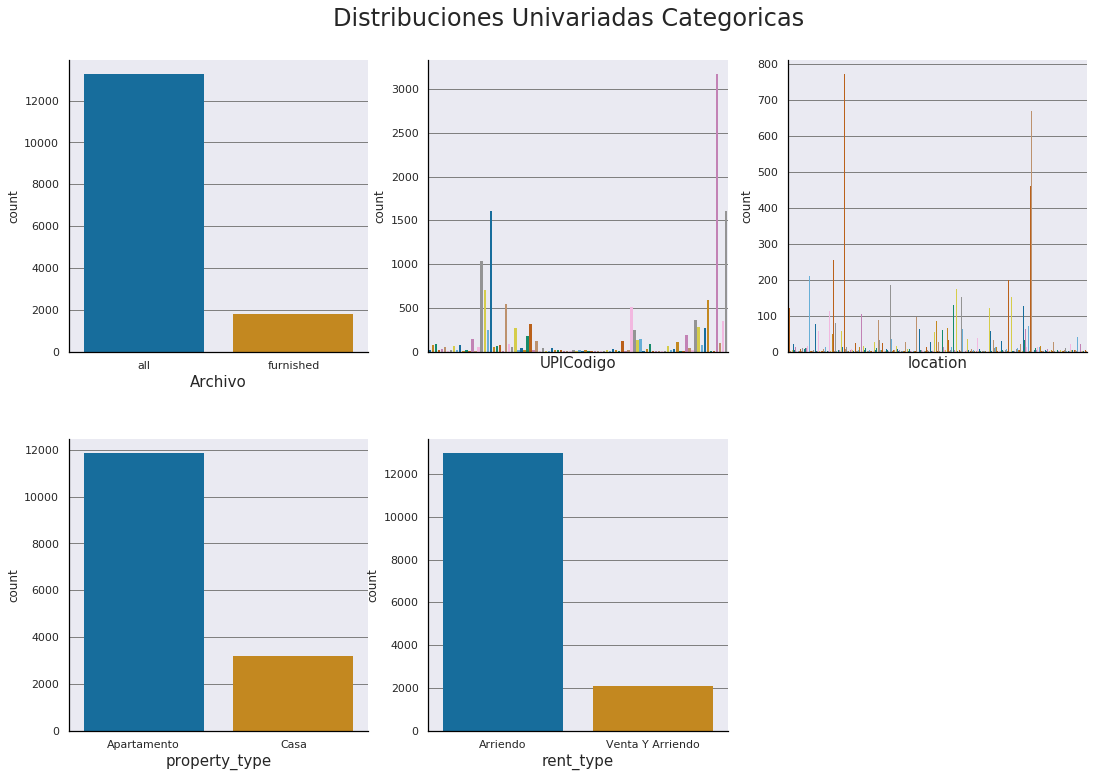

In [16]:
distribucion('Categoricas', Categoricas)

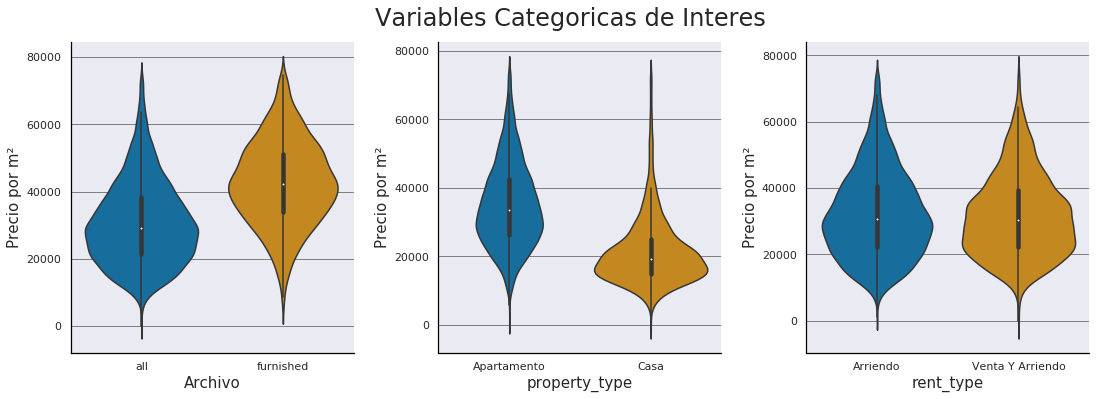

In [17]:
cat_interes=Categoricas.copy()
for d in ['UPlCodigo', 'location']:
    cat_interes.remove(d)
interes('Categoricas', cat_interes)

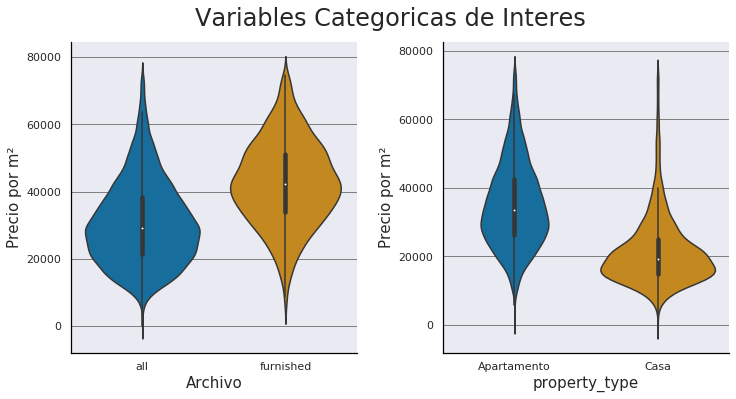

In [18]:
#Finales de interes:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout()
fig.suptitle('Variables Categoricas de Interes', fontsize=24,x=0.5,y=1.05)
sns.violinplot(x=('Categoricas', 'Archivo'), y=('Numericas', 'Precio_m2'), data=df, ax=ax[0],
               kind='violin', palette='colorblind', order=np.unique(df[('Categoricas','Archivo')]))
sns.violinplot(x=('Categoricas', 'property_type'), y=('Numericas', 'Precio_m2'), data=df, ax=ax[1],
               kind='violin', palette='colorblind', order=np.unique(df[('Categoricas','property_type')]))
ax[0].set_xlabel('Archivo', fontsize=15)
ax[1].set_xlabel('property_type', fontsize=15)
ax[0].set_ylabel('Precio por m²', fontsize=15)
ax[1].set_ylabel('Precio por m²', fontsize=15)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.show()
fig.savefig('./fig/Categoricas_interes.pdf', bbox_inches='tight')

## Variables Ordinales

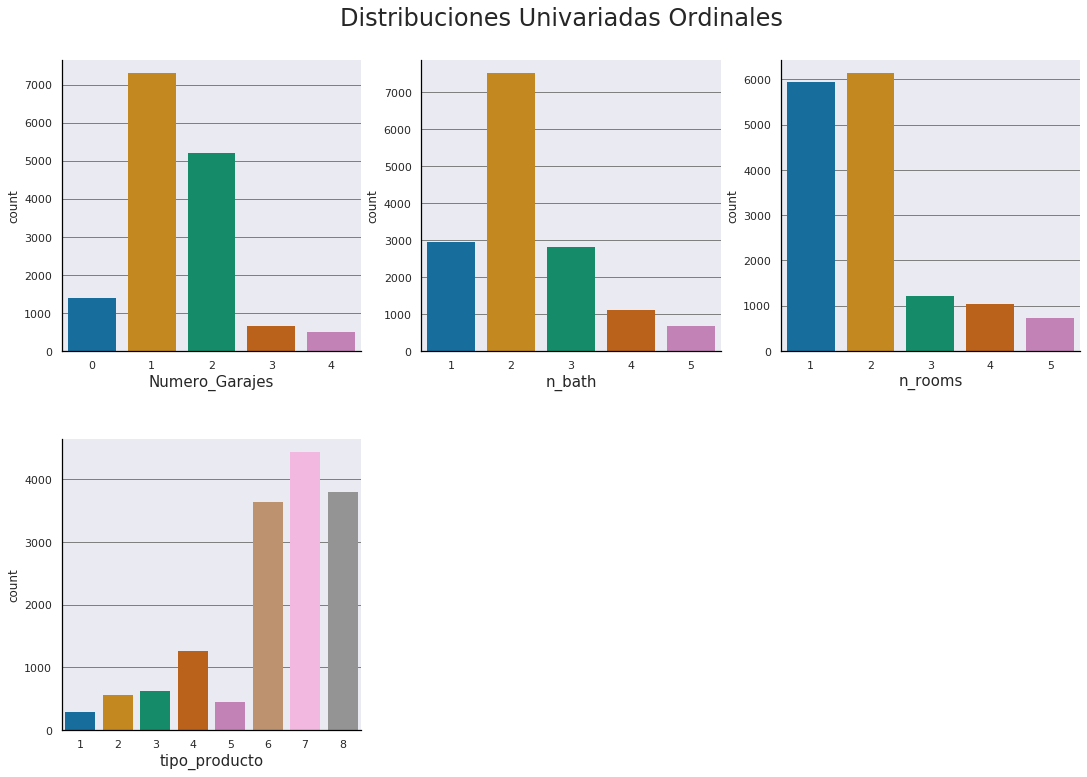

In [19]:
distribucion('Ordinales', Ordinales)

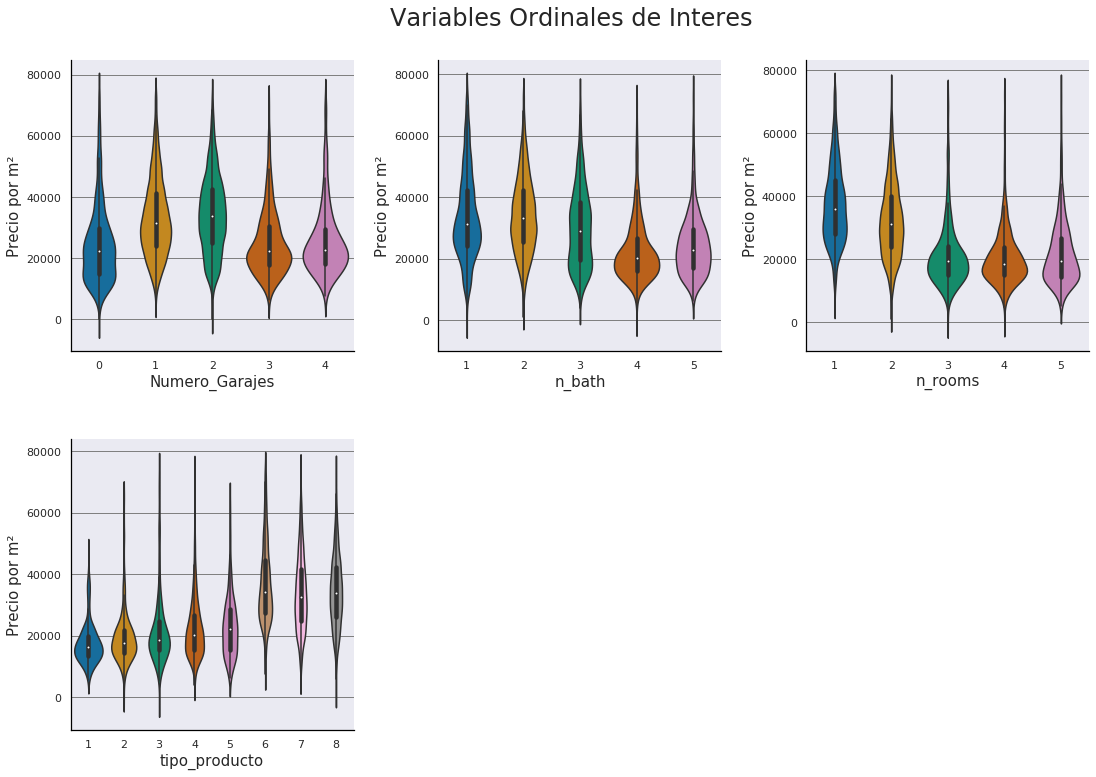

In [20]:
ord_interes=Ordinales.copy()
interes('Ordinales', ord_interes)

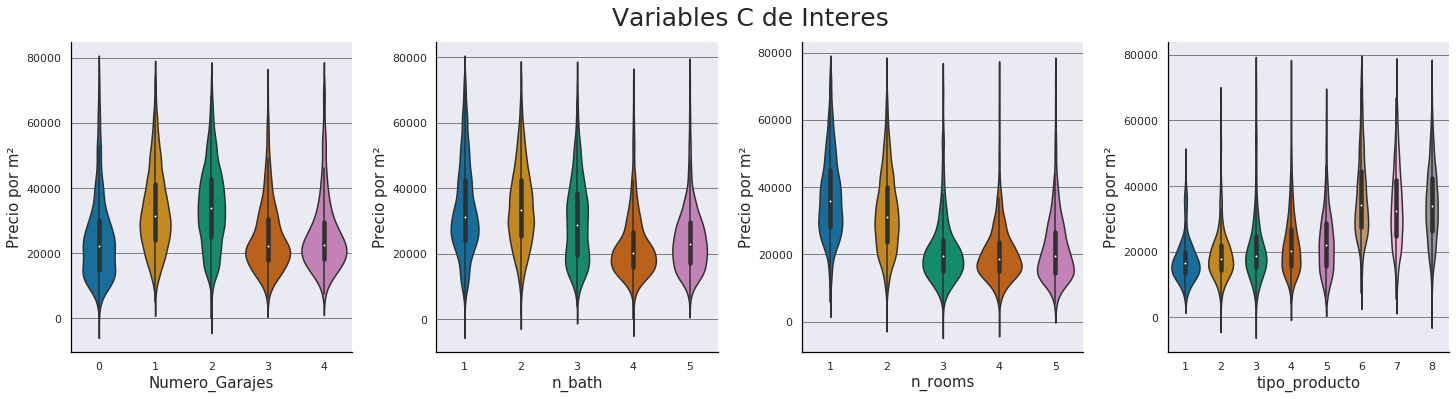

In [21]:
#Ploteo final arreglado para el informe:
fig, ax = plt.subplots(1,4, figsize=(20,5))
fig.tight_layout()
fig.suptitle('Variables Categoricas de Interes', fontsize=25,x=0.5,y=1.05)
for col, axis in zip(['Numero_Garajes', 'n_bath', 'n_rooms', 'tipo_producto'], ax.flatten()):
    sns.violinplot(x=('Ordinales', col), y=('Numericas', 'Precio_m2'), data=df, ax=axis,
                   kind='violin', palette='colorblind', order=np.unique(df[('Ordinales',col)]))
    axis.set_xlabel(col, fontsize=15)
    axis.set_ylabel('Precio por m²', fontsize=15)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.show()
fig.savefig('./fig/Ordinales_interes.pdf', bbox_inches='tight')

## Variables Numéricas

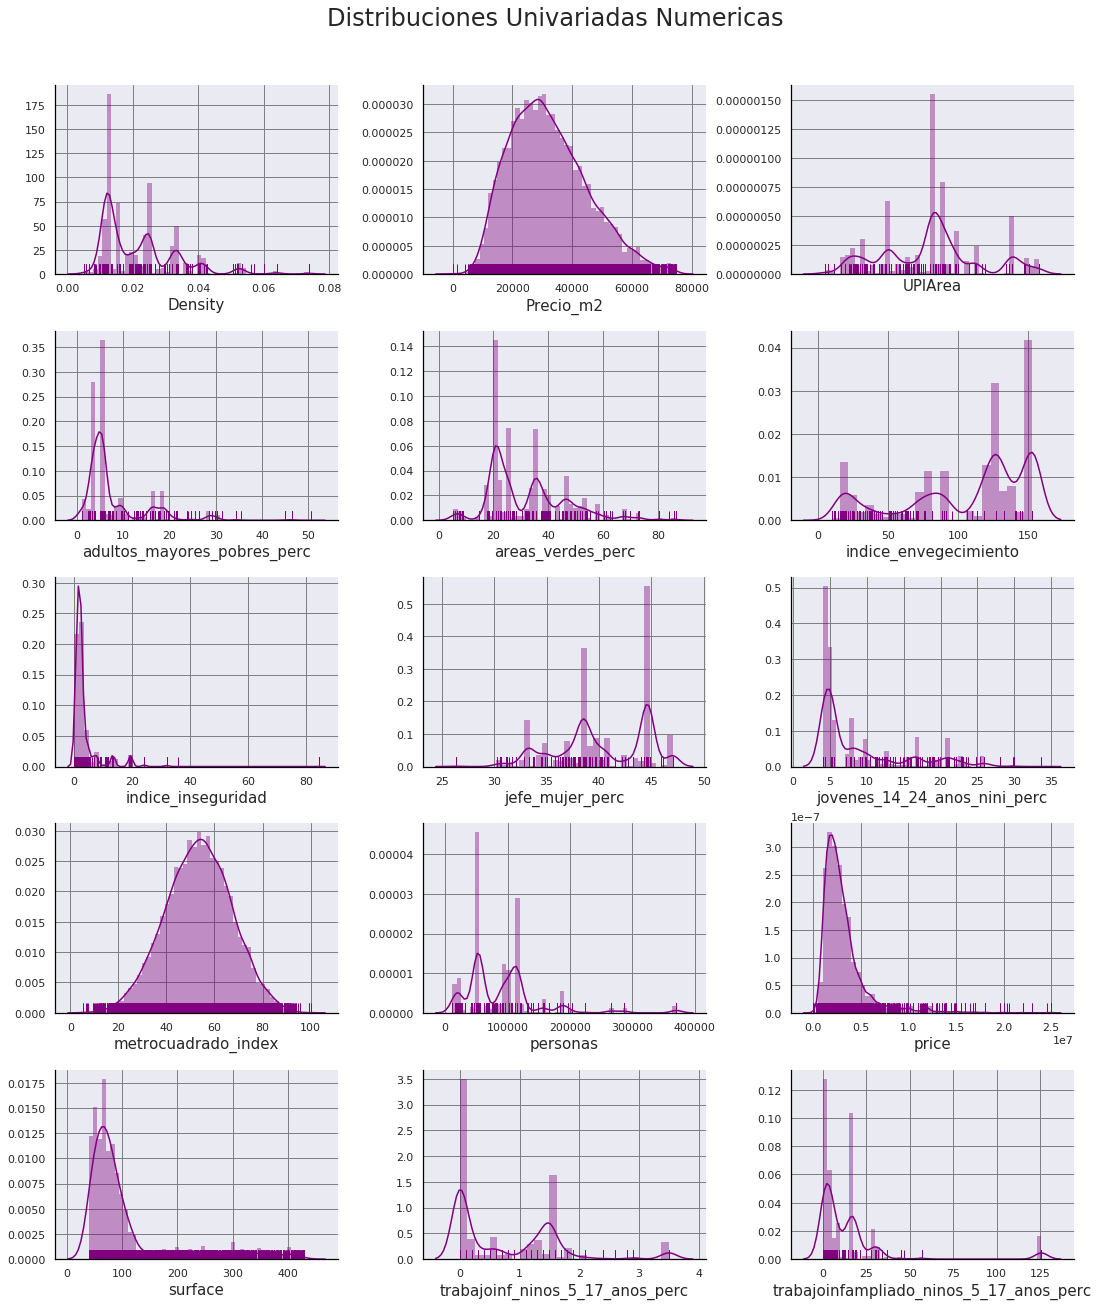

In [22]:
distribucion('Numericas', Numericas)

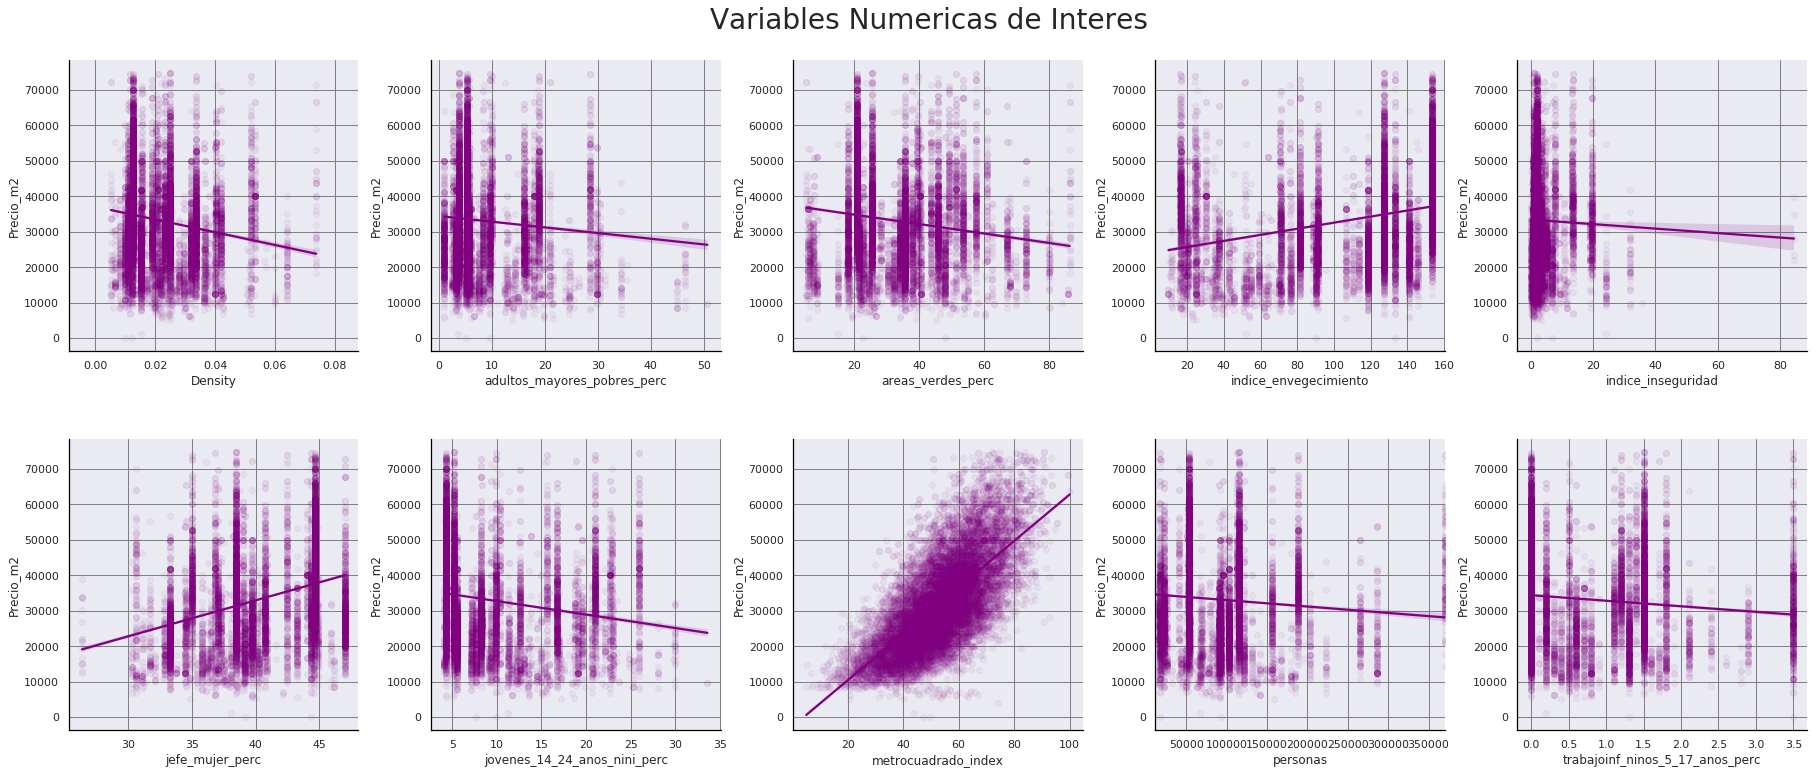

In [24]:
#Se borran distribuciones sin relacion clara y las obvias, se plotea las var numericas finales para el informe
num_interes=Numericas.copy()
for d in ['price','surface', 'Precio_m2', 'trabajoinfampliado_ninos_5_17_anos_perc', 'UPlArea']:
    num_interes.remove(d)
    
fig = interes('Numericas', num_interes)
fig.savefig('./fig/num_interes.png', bbox_inches='tight', dpi=90)

3. Estudie la presencia de datos faltantes en la base de datos. Observe como se distribuyen estos y establezca un mecanismo de pérdida de información basándose en los patrones observables del conjunto de datos. Busque agrupaciones de columnas que muestren un comportamiento sistemático y plantee sus reflexiones.\
Respalde con visualizaciones y cuantifique estadísticamente los patrones observados.

In [25]:
import missingno as msno

In [26]:
df = pd.read_pickle('./data/data_perfilada.pkl')
df.replace('nan',np.nan, inplace = True)
df.isnull().sum().nlargest(15)

Numericas    Density                                    1635
             UPlArea                                    1635
             adultos_mayores_pobres_perc                1635
             areas_verdes_perc                          1635
             indice_envegecimiento                      1635
             indice_inseguridad                         1635
             jefe_mujer_perc                            1635
             jovenes_14_24_anos_nini_perc               1635
             personas                                   1635
             trabajoinf_ninos_5_17_anos_perc            1635
             trabajoinfampliado_ninos_5_17_anos_perc    1635
Categoricas  UPlCodigo                                  1635
Numericas    Precio_m2                                     0
             metrocuadrado_index                           0
             price                                         0
dtype: int64

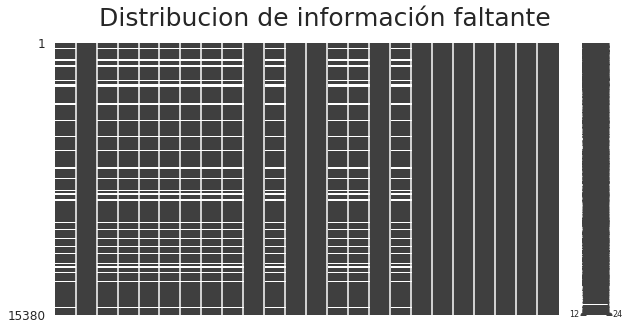

In [27]:
#Ploteo final para informe
fig =msno.matrix(df[df.isnull().sum().index], 
                 labels=False,
                 sparkline=True, figsize=(10,5), fontsize=10)
fig_copy = fig.get_figure()
fig_copy.suptitle('Distribucion de información faltante', fontsize=25)
fig_copy.savefig('./fig/missing_dist.pdf',bbox_inches='tight')

## Little's MCAR test

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer

In [32]:
df=pd.read_pickle('./data/data.pkl')

num_cols = ['metrocuadrado_index','trabajoinf_ninos_5_17_anos_perc', 'UPlArea', 'personas',
            'price', 'surface', 'trabajoinfampliado_ninos_5_17_anos_perc', 
            'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento','jefe_mujer_perc', 
            'adultos_mayores_pobres_perc', 'indice_inseguridad', 'areas_verdes_perc', 'Density']

ordinal_cols = ['Numero_Garajes','n_bath','n_rooms','tipo_producto']
cat_cols = ['property_type', 'rent_type', 'Archivo', 'UPlCodigo', 'location']

# Adquieren las categorias de cada variable
ordinal_cat = [['0', '1', '2', '3', '4', '4+'],
               ['1', '2', '3', '4', '5', '5+'],
               ['1', '2', '3', '4', '5', '5+'],
               [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]]

In [33]:
# Pipeline categorica
cat_pipe = Pipeline(
    steps=[('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')), 
           ('onehot',OneHotEncoder(sparse=False, handle_unknown='ignore'))])
# Pipeline Numerica
num_pipe = Pipeline(steps=[('quantile', QuantileTransformer())]) #Quita peso a outliers
# Pipeline Ordinal
ord_pipe = Pipeline(
    steps=[('imputer_ord', SimpleImputer(strategy='constant', fill_value='NA')),
           ('ordinal', OrdinalEncoder(categories = ordinal_cat))])

#Preprocesador Compuesto
prep = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols), 
                  ('cat', cat_pipe, cat_cols), 
                  ('ord', ord_pipe, ordinal_cols)])

In [34]:
X=df.drop([col for col in ['Precio_m2']], axis=1).copy()
y = df['Precio_m2'].copy()
X_prep = prep.fit_transform(X)

# Se obtienen las variables categoricas transformadas
post_cat = prep.named_transformers_['cat'][-1]
cat_cols_fit = post_cat.get_feature_names(cat_cols)
post_cols = list(num_cols)+list( cat_cols_fit) + list(ordinal_cols)

df_post = pd.DataFrame(data=X_prep, columns=post_cols)

In [35]:
from mcar import little_mcar
chi, d, p = little_mcar(df_post).values()
if p<0.001: print('Se rechaza H_0: No es MCAR p =', p)
else: print('No se puede rechazar H_0.')

Se rechaza H_0: No es MCAR p = 5.109278849757537e-05


## Iterative Imputer

Como no es MCAR, se asume que es MAR, luego se implementa un iterative imputer para rellenar los datos faltantes, ya que de esta forma se puede preservar mejor la varianza de los datos.

In [37]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, QuantileTransformer

In [38]:
rf = RandomForestRegressor(random_state=0, n_estimators=5, n_jobs=4)

imputer_RF = IterativeImputer(estimator=rf,
                              skip_complete=True,
                              verbose=1,
                              random_state=1)

In [39]:
A=imputer_RF.fit_transform(df_post)

[IterativeImputer] Completing matrix with shape (15394, 677)
[IterativeImputer] Change: 2.3043608609998723, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.6122851014225612, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.8515307548146387, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.42288264077656595, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.7643553613342584, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.5329628142683303, scaled tolerance: 0.007 
[IterativeImputer] Change: 1.0988311368994954, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.8547401519978479, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.36716743517519124, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.6607652055918125, scaled tolerance: 0.007 


In [41]:
df_A=pd.DataFrame(A, index=df_post.index, columns=df_post.columns)
df_A.head()

,metrocuadrado_index,trabajoinf_ninos_5_17_anos_perc,UPlArea,personas,price,surface,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,...,location_villas del madrigal,location_villas del mediterraneo,location_villemar fontibon,location_viveros,location_zona franca,location_zona industrial,Numero_Garajes,n_bath,n_rooms,tipo_producto
0,0.606106,0.579680,0.172304,0.486687,0.776376,0.712212,0.296797,0.786086,0.180618,0.527427,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0
1,0.001205,0.579680,0.172304,0.486687,0.008509,0.645145,0.296797,0.786086,0.180618,0.527427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2,0.324324,0.912913,0.274274,0.133133,0.184852,0.687688,0.588589,0.687187,0.170671,0.181682,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,0.0
3,0.479479,0.579680,0.172304,0.486687,0.135135,0.571572,0.296797,0.786086,0.180618,0.527427,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0
4,0.078078,0.579680,0.172304,0.486687,0.135135,0.712212,0.296797,0.786086,0.180618,0.527427,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0


In [42]:
#Se recuperan valores originales y se transforman los llenados a los valorees originales
QT = QuantileTransformer()
QT.fit_transform(X[num_cols])

df_A=pd.DataFrame(QT.inverse_transform(df_A[num_cols]), index=df_A.index, columns=num_cols)
df_A[cat_cols]=df[cat_cols]
df_A[ordinal_cols]=df[ordinal_cols]

#UPlCodigo y UPlNombre no se pueden llenar, luego se agrega categoria nan
df_A.replace(np.nan, 'Otro', inplace=True)

In [43]:
df_A['Precio_m2']=df['Precio_m2']
num_cols.append('Precio_m2')
num_cols.sort()
cat_cols.sort()
ordinal_cols.sort()

'''Se eliminan algunas observaciones para poder transformar'''
df_A=df_A[df.Numero_Garajes!='4+'] #9 obs
df_A=df_A[df.n_rooms!='5+'] #8 obs
df_A=df_A[df.n_bath!='5+']  #7 obs

df_A = df_A.astype({col:'str' for col in cat_cols})
df_A = df_A.astype({col:'int' for col in ordinal_cols})
df_A = df_A.astype({col:'float64' for col in num_cols})

mapping = [('Numericas', col) for col in num_cols]
mapping.extend([('Categoricas', col) for col in cat_cols])
mapping.extend([('Ordinales', col) for col in ordinal_cols])

df_A = df_A.reindex(columns=num_cols + cat_cols + ordinal_cols)
df_A.columns = pd.MultiIndex.from_tuples(mapping)

df_A.to_pickle('./data/data_RF.pkl')

4. Recategoríce la variable código de UPZ de forma que quede distribuida entre 3 a 5 grupos, evalúe la significancia estadística de esta nueva agrupación en comparación a la variable de respuesta. Comente sus resultados e interprételos.\
__Hint:__ Puede probar con técnicas de clustering (como k-means) sobre una agrupación de UPZ y validar estadísticamente si las nuevas categorías afectan la variable de respuesta.

In [44]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import f_oneway

In [89]:
'''Se leen datos llenados y transformados'''
df=pd.read_pickle('./data/data_RF.pkl')

'''No considero outliers de algunas columnas (solucion por ahora)'''
for col in ['Precio_m2','surface']:
    q = df.Numericas[col].quantile(0.995)
    df=df[df.Numericas[col] < q]

'''Creo DataFrame auxiliar con hot encoding'''
encoding = pd.get_dummies(df['Categoricas']['UPlCodigo'])
encoding['Precio_m2']=df['Numericas']['Precio_m2']
encoding['UPlCodigo']=df['Categoricas']['UPlCodigo']

Xdata=pd.DataFrame(encoding.iloc[:,:-2], 
                   index=encoding.iloc[:,:-2].index, 
                   columns=encoding.iloc[:,:-2].columns)

In [49]:
def upzcluster(n, encoding=encoding, data=Xdata):
    '''
    Funcion para comparar la calidad de clusterizacion:
        n: el numero de clusters deseado
        encoding, data: las variables auxiliares definidas anteriormente
    
    Imprime en pantalla puntajes de clusterizacion y test para verificar 
    cuanto afecta en la variable de respuesta (Precio_m2). 
    Finalmente plotea el grafo de violin para el cluster para constrastar
    con el test estadistico.
    '''
    kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
    labels=kmeans.labels_
    aux=encoding.copy()
    aux['label']=labels

    fig, ax = plt.subplots(2,1,figsize=(8,8))
    fig.suptitle('Analisis N° Cluster = '+str(n))

    sns.violinplot(x='label',y='Precio_m2',data=aux,kind='violin',ax=ax[0])

    sns.countplot(aux['label'], ax=ax[1])

    ax[0].set_xlabel('UPZ cluster')
    ax[1].set_xlabel('UPZ Cluster')

    ax[0].set_ylabel('Precio por m²')
    ax[0].set_title('Violin plot UPZ vs Price_m²')
    ax[1].set_title('Frecuencias UPZ Cluster')

    h, w = (.3, .1)
    plt.subplots_adjust(wspace=w, hspace=h)
    fig.show()
    fig.savefig('./fig/'+str(n)+'_clusters.pdf')
    
    aux=aux.iloc[:,-3:]
    clusters=aux.copy()    
    aux.drop('UPlCodigo', axis=1, inplace=True)
    group_to_test=[]
    for m in np.unique(aux.label):
        group_to_test.append(aux[aux.label==m][['Precio_m2']])
    F,p = f_oneway(*group_to_test)
    alpha = 0.05
    
    print('N =', n)
    print('silhouette:',silhouette_score(data,labels))
    print('calinski harabasz:',calinski_harabasz_score(data, labels))
    print('Estadistico F:',F)
    print('p valor :', p)
    if p <= alpha: print('N =',n,'apaña')
    print('='*80)
    return clusters

N = 3
silhouette: 0.35638824750653847
calinski harabasz: 3240.662616847334
Estadistico F: [2364.39162533]
p valor : [0.]
N = 3 apaña
N = 4
silhouette: 0.44983723673502185
calinski harabasz: 3388.622979750216
Estadistico F: [1676.60311609]
p valor : [0.]
N = 4 apaña
N = 5
silhouette: 0.4827169054505124
calinski harabasz: 2944.573502533495
Estadistico F: [1385.3945366]
p valor : [0.]
N = 5 apaña


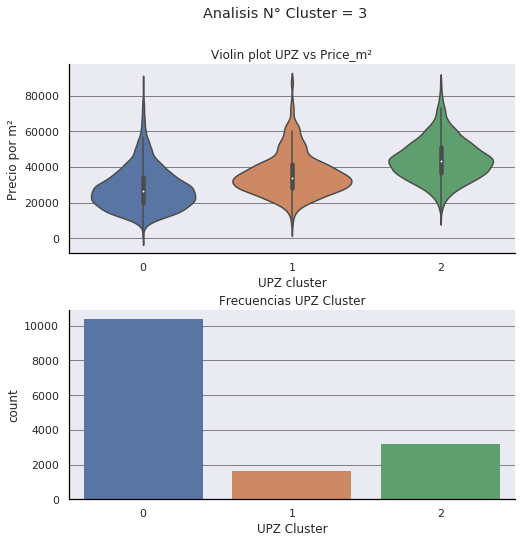

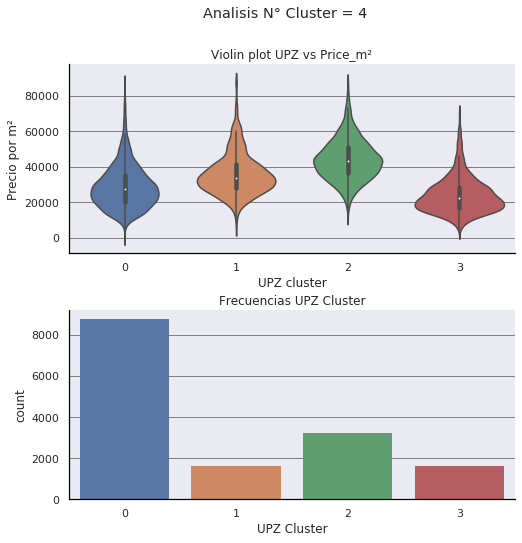

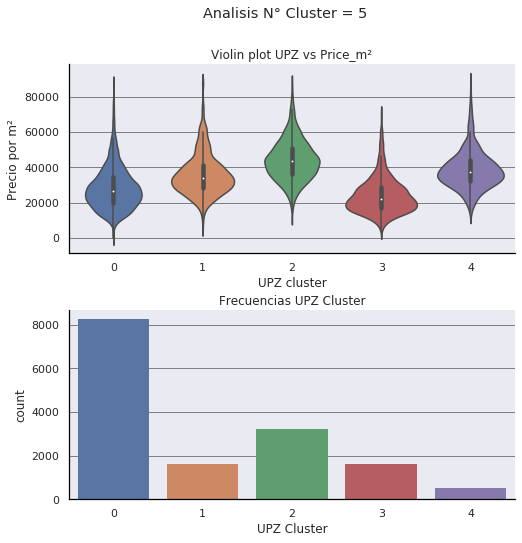

In [50]:
Groups=[]
for m in [3,4,5]:
    Groups.append(upzcluster(m))

In [90]:
#Se decide agruparlos de a 3:
cluster=Groups[0].iloc[:,-1:]
df[('Ordinales','UPlCluster')]=cluster.label
df.sort_index(level=0, axis=1, inplace=True)
df.to_pickle('./data/data_cluster.pkl')

5. Cuantifique estadísticamente las relaciones entre una selección de al menos 10 variables de interés y la columna de respuesta, examine también las relaciones entre las variables de su selección. Utilice las herramientas de análisis estadístico que considere pertinentes, comente brevemente sus hallazgos.

## Análisis Datos llenados

In [55]:
def indexer(cols, t_c = df.columns):
    '''Genera columnas multinivel a partir de nombres de columna planos.'''
    #Creditos C9 DataScienceLab
    
    set_to_tuple = set(*[cols])
    tuples = [
        i for i in t_c if set_to_tuple.intersection(set(i))
    ]
    return tuples

In [56]:
'''
Se cargan datos transformados por QuantileTransformer, llenados segun RF e IterativeImputer.
También se agruparon los codigos en UPlClusters segun los resultados de la parte 4 (3 grupos)
Cluster 1: Obs sin codigo UPZ
Cluster 2: Obs con codigo UPZ97
Cluster 0: Todos los demas
'''
df=pd.read_pickle('./data/data_cluster.pkl')
col_interes = ['Archivo', 'property_type', 
           
           'Numero_Garajes', 'n_bath', 'n_rooms', 'tipo_producto',
           
           'Density', 'areas_verdes_perc', 'indice_envegecimiento',
           'jefe_mujer_perc', 'metrocuadrado_index', 'Precio_m2',
           
           'adultos_mayores_pobres_perc', 'indice_inseguridad',
           'jovenes_14_24_anos_nini_perc', 'personas',
           'trabajoinf_ninos_5_17_anos_perc']
idxs = indexer(col_interes)
df=df[idxs]
df.head()

Categoricas               Numericas                \
      Archivo property_type   Density     Precio_m2   
0         all          Casa  0.032135  39300.000000   
1         all          Casa  0.032135   8333.333333   
2         all          Casa  0.017215  16250.000000   
3         all          Casa  0.032135  17073.170732   
4         all          Casa  0.032135  14000.000000   

                                                                       \
  adultos_mayores_pobres_perc areas_verdes_perc indice_envegecimiento   
0                    6.146129         35.573427              62.40625   
1                    6.146129         35.573427              62.40625   
2                    5.420442         32.395663              54.70000   
3                    6.146129         35.573427              62.40625   
4                    6.146129         35.573427              62.40625   

                                                                   \
  indice_inseguridad jefe_mujer_perc jovenes_14_24_anos_nini_perc   
0           0.654450       39.741321                         12.6   
1           0.654450       39.741321                         12.6   
2           3.166227       36.279630                          9.1   
3           0.654450       39.741321                         12.6   
4           0.654450       39.741321                         12.6   

                                                                    Ordinales  \
  metrocuadrado_index personas trabajoinf_ninos_5_17_anos_perc Numero_Garajes   
0                57.3  88155.0                             0.8              1   
1                12.2  88155.0                             0.8              0   
2                47.1  50037.0                             1.8              1   
3                52.9  88155.0                             0.8              1   
4                33.3  88155.0                             0.8              1   

                                
  n_bath n_rooms tipo_producto  
0      2       3             1  
1      1       3             1  
2      3       4             1  
3      2       4             1  
4      2       4             1

### Variables Numéricas

In [59]:
corrmat = df.Numericas.corr()
corrmat[['Precio_m2']].abs().nlargest(14, ['Precio_m2'])

,Precio_m2
Precio_m2,1.000000
metrocuadrado_index,0.691390
indice_envegecimiento,0.330829
jefe_mujer_perc,0.320708
jovenes_14_24_anos_nini_perc,0.206071
Density,0.202182
areas_verdes_perc,0.147578
trabajoinf_ninos_5_17_anos_perc,0.107326
personas,0.078128
adultos_mayores_pobres_perc,0.061009


Se borran las 3 menos correlacionadas

In [60]:
df.drop([('Numericas', col) for col in ['indice_inseguridad', 'personas', 'adultos_mayores_pobres_perc']],
        axis=1, inplace=True)

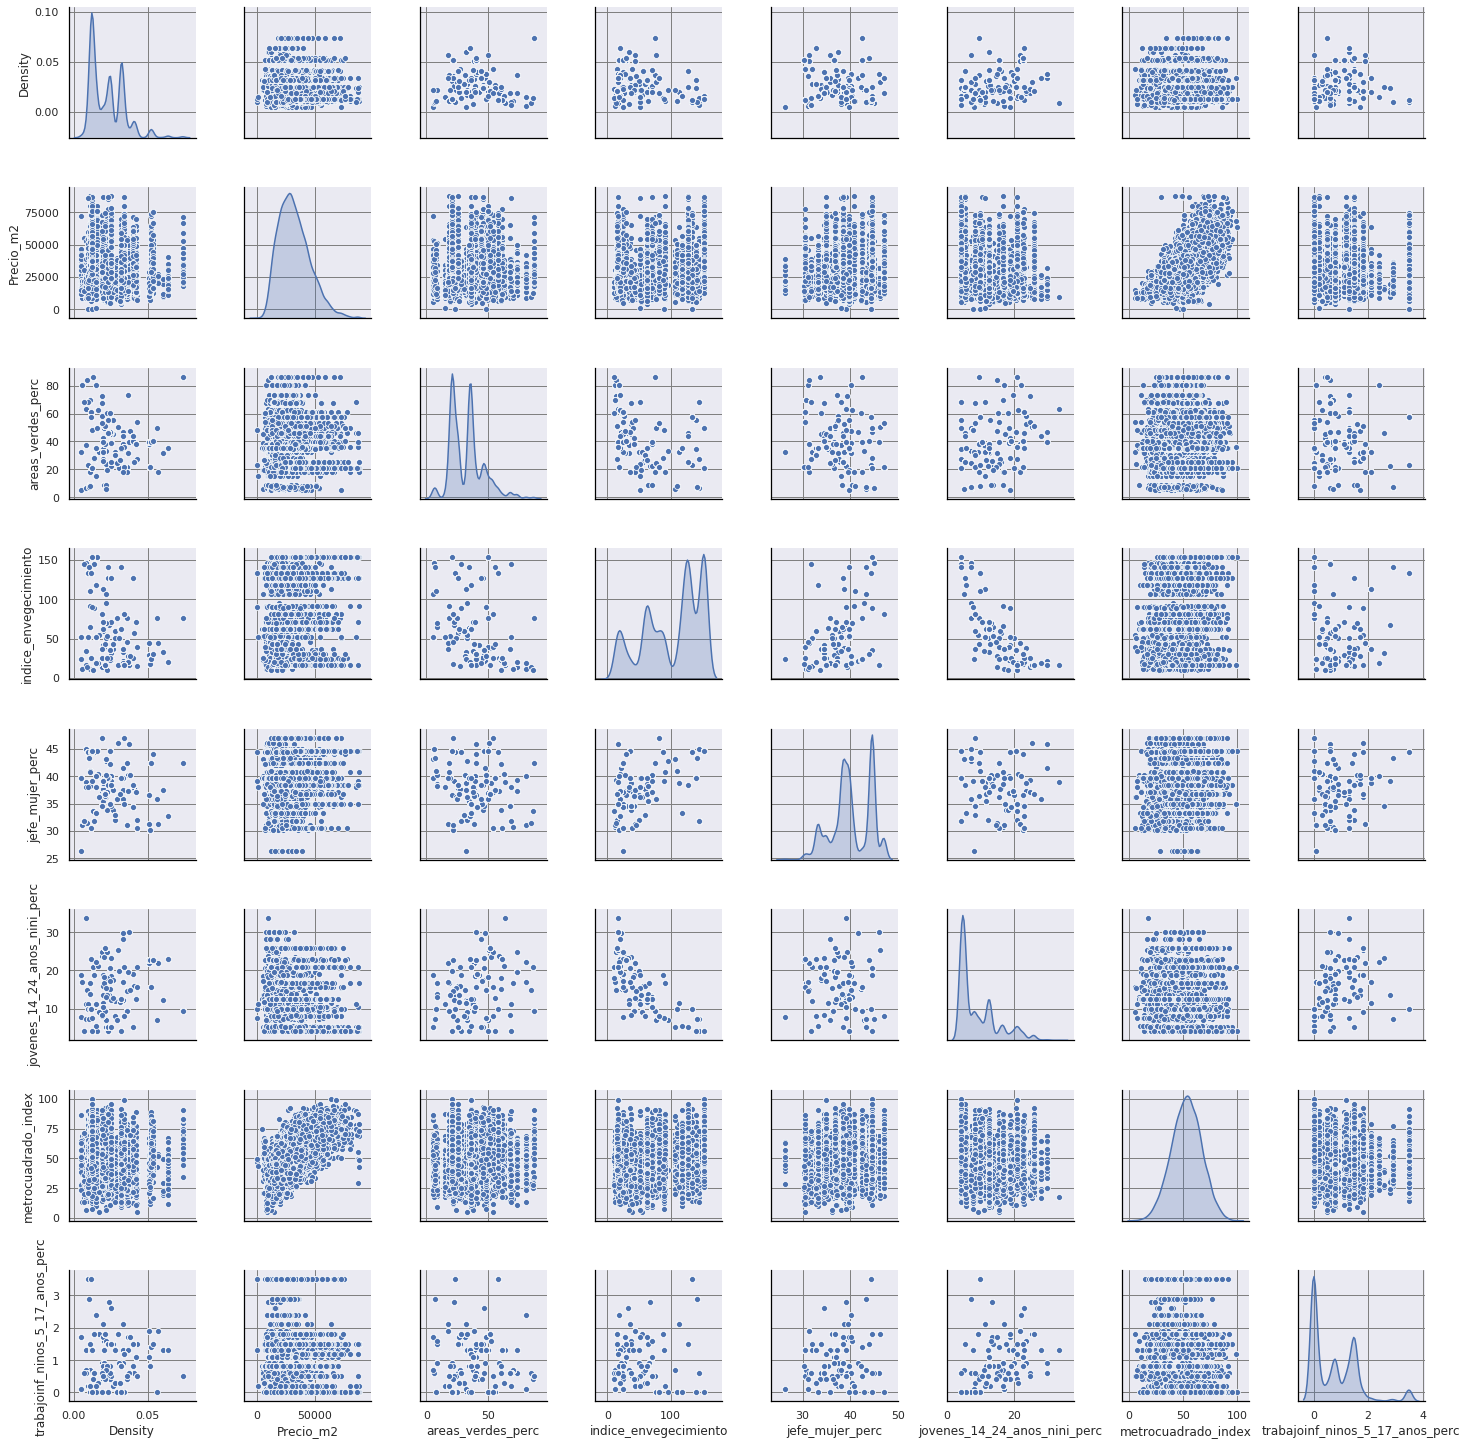

In [68]:
data = df.Numericas.copy()
sns.pairplot(data = data, diag_kind='kde')

Se observan relaciones entre las variables ``indice_envegecimiento``, ``jefe_mujer_perc``, ``jovenes_14_24_anos_nini_perc`` y ``areas_verdes_perc``

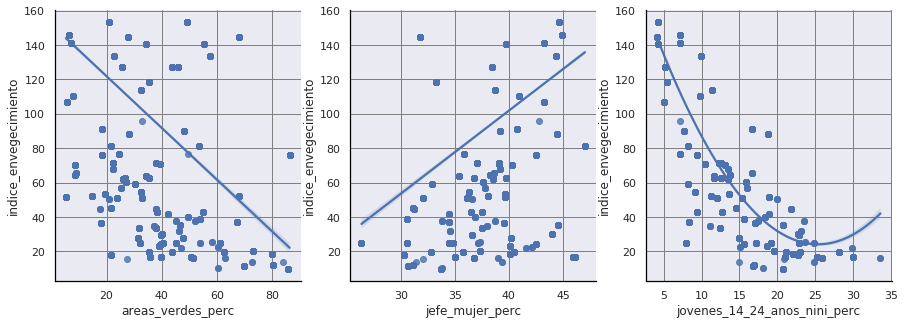

In [69]:
fig , ax = plt.subplots(1,3, figsize=(15,5))
sns.regplot(y='indice_envegecimiento', x='areas_verdes_perc', data=df.Numericas, order=1, ax=ax[0])
sns.regplot(y='indice_envegecimiento', x='jefe_mujer_perc', data=df.Numericas, order=1, ax=ax[1])
sns.regplot(y='indice_envegecimiento', x='jovenes_14_24_anos_nini_perc', data=df.Numericas, order=2, ax=ax[2])
fig.show()

Para no tener problemas con las hipotesis del modelo lineal se tomara la mas correlacionada con la variable de respuesta, en este caso ``indice_envegecimiento``

In [70]:
df.drop([('Numericas', col) for col in ['areas_verdes_perc', 'jefe_mujer_perc', 'jovenes_14_24_anos_nini_perc']],
        axis=1, inplace=True)

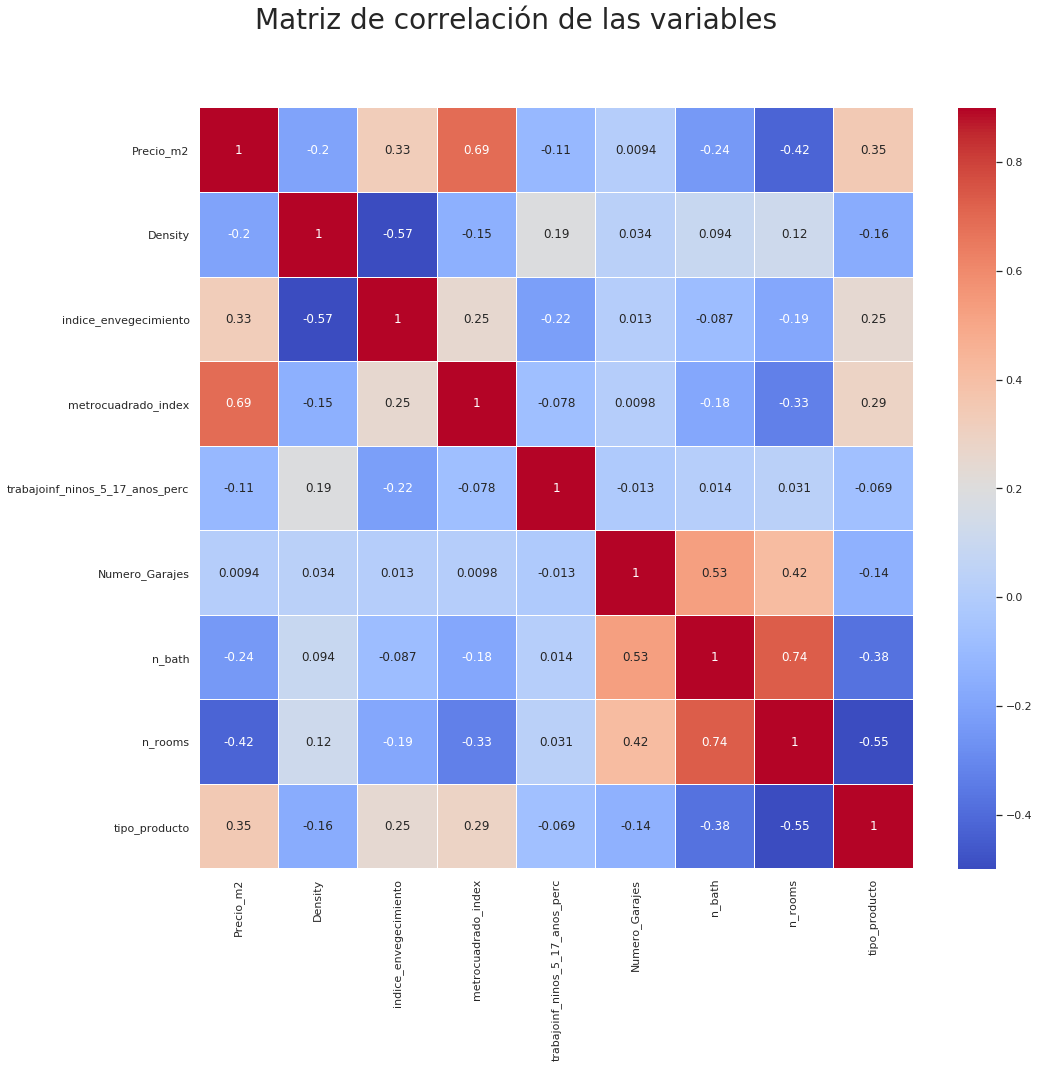

In [72]:
corrmat = df.corr()
col = indexer(['Precio_m2'], df.columns)

unsorted = list(corrmat.columns)
unsorted.remove(*col)
unsorted.insert(0, *col)

sortd = pd.MultiIndex.from_tuples(unsorted)
corrmat = corrmat.reindex(index = sortd, columns = sortd)
etiquetas=list(corrmat.columns.droplevel(0).values)

fig, ax = plt.subplots(figsize=[16, 14])
fig.suptitle('Matriz de correlación de las variables',fontsize=28, x=0.4)
ax=sns.heatmap(corrmat, vmin=-.5, vmax=.9, linewidths=.01, cmap='coolwarm', annot=True, fmt='.2g',
              yticklabels=etiquetas, xticklabels=etiquetas)
ax.set_xlabel('')
ax.set_ylabel('')
fig.savefig('./fig/matriz_corr.pdf', bbox_inches='tight')

### Variables Ordinales

De la matriz anterior se ve una fuerte correlacion entre las variables ``n_bath`` y ``n_rooms``. También se observa menos fuerte entre ``Numero_Garajes`` y las dos anteriores. Por último se ve una relacion entre ``tipo_producto`` y ``n_bath``, ``n_rooms``

In [73]:
from scipy.stats import chi2_contingency

In [74]:
def compara_vars(ord1, ord2, tipo='Ordinales', df=df):
    to_compare =[ord1,ord2]
    data_ord = df[tipo]
    kwargs = {'index': data_ord[to_compare[0]], 'columns': data_ord[to_compare[1]]}
    tabla = pd.crosstab(**kwargs, margins=False)
    chi2, p, dof, ex =chi2_contingency(tabla)
    
    expected_freq = pd.DataFrame(ex, 
                                 index=np.unique(df[tipo][ord1]), 
                                 columns=np.unique(df[tipo][ord2]))
    expected_freq.index.name = ord1
    expected_freq.columns.name = ord2
    if p<=0.01:
        print('Existe una dependencia entre las variables',ord1, 'y', ord2, ', p =', p)
    else:
        print('No se puede rechazar H_0. No hay dependencia')
    
    return expected_freq

In [76]:
l1=['n_bath','Numero_Garajes','Numero_Garajes','tipo_producto','tipo_producto']
l2=['n_rooms', 'n_rooms','n_bath','n_bath', 'n_rooms']
for ord1, ord2 in zip(l1,l2):
    print(ord1,'vs',ord2)
    print('='*80)
    display(compara_vars(ord1,ord2))
    print('='*80)

n_bath vs n_rooms
Existe una dependencia entre las variables n_bath y n_rooms , p = 0.0


n_rooms,1,2,3,4,5
n_bath,,,,,
1,1179.080644,1203.383503,239.696747,209.514164,150.324942
2,2979.728952,3041.146237,605.752744,529.476438,379.895629
3,1118.189155,1141.236937,227.318041,198.694183,142.561683
4,448.778179,458.028262,91.232665,79.744660,57.216234
5,290.223069,296.205061,58.999803,51.570555,37.001512


Numero_Garajes vs n_rooms
Existe una dependencia entre las variables Numero_Garajes y n_rooms , p = 0.0


n_rooms,1,2,3,4,5
Numero_Garajes,,,,,
0,561.071574,572.636214,114.060927,99.698390,71.532895
1,2900.649096,2960.436411,589.676503,515.424515,369.813474
2,2074.660007,2117.422281,421.760171,368.652185,264.505357
3,269.662307,275.220506,54.819980,47.917056,34.380151
4,209.957016,214.284588,42.682419,37.307854,26.768124


Numero_Garajes vs n_bath
Existe una dependencia entre las variables Numero_Garajes y n_bath , p = 0.0


n_bath,1,2,3,4,5
Numero_Garajes,,,,,
0,278.110943,702.831679,263.748406,105.853763,68.455209
1,1437.788498,3633.525863,1363.536510,547.246796,353.902333
2,1028.363720,2598.842721,975.255734,391.412751,253.125074
3,133.665725,337.795071,126.762800,50.875452,32.900953
4,104.071114,263.004666,98.696549,39.611239,25.616431


tipo_producto vs n_bath
Existe una dependencia entre las variables tipo_producto y n_bath , p = 0.0


n_bath,1,2,3,4,5
tipo_producto,,,,,
1,57.425304,145.123102,54.459678,21.857049,14.134867
2,109.558856,276.873086,103.900887,41.699967,26.967203
3,123.866185,313.030036,117.469339,47.145580,30.488860
4,248.516333,628.041275,235.682156,94.589550,61.170687
5,102.895169,260.032862,97.581334,39.163654,25.326980
6,723.794019,1829.145449,686.414985,275.488334,178.157213
7,870.787118,2200.620966,825.816891,331.436411,214.338613
8,745.157016,1883.133224,706.674729,283.619454,183.415577


tipo_producto vs n_rooms
Existe una dependencia entre las variables tipo_producto y n_rooms , p = 0.0


n_rooms,1,2,3,4,5
tipo_producto,,,,,
1,115.851988,118.239895,23.551692,20.586066,14.770358
2,221.028196,225.583963,44.933092,39.275123,28.179625
3,249.892343,255.043050,50.800920,44.404075,31.859612
4,501.366283,511.700296,101.923365,89.089188,63.920868
5,207.584620,211.863293,42.200131,36.886296,26.465659
6,1460.209530,1490.306934,296.847782,259.468748,186.167006
7,1756.758988,1792.968781,357.133684,312.163457,223.975090
8,1503.308051,1534.293789,305.609333,267.127046,191.661781


In [77]:
for col in ['n_bath', 'n_rooms', 'tipo_producto', 'Numero_Garajes']:
    group_to_test=[]
    for m in np.unique(df.Ordinales[col].values):
        group_to_test.append(df.Numericas[df.Ordinales[col]==m][['Precio_m2']])
    F,p = f_oneway(*group_to_test)
    alpha = 0.05
    if p<alpha: 
        print(col)
        print('p =',p[0])
        print('F =', F[0])

n_bath
p = 7.771301541463415e-255
F = 307.5308549708032
n_rooms
p = 0.0
F = 942.144217943266
tipo_producto
p = 0.0
F = 503.88026900557327
Numero_Garajes
p = 1.1587353711335322e-209
F = 251.59993104873035


Aca vemos que ``n_rooms`` explica mejor ``Precio_m2``, asi que en caso que la dependencia entre variables provocara algun mal comportamiento en nuestro modelo final, se consideraría solo esta variable.

### Variables categóricas

In [78]:
compara_vars('Archivo', 'property_type', 'Categoricas')

Existe una dependencia entre las variables Archivo y property_type , p = 5.979623001695539e-65


property_type,Apartamento,Casa
Archivo,,
all,10512.34466,2885.65534
furnished,1425.65534,391.34466


In [80]:
for col in ['Archivo', 'property_type']:
    group_to_test=[]
    for m in np.unique(df.Categoricas[col].values):
        group_to_test.append(df.Numericas[df.Categoricas[col]==m][['Precio_m2']])
    F,p = f_oneway(*group_to_test)
    alpha = 0.05
    if p<alpha: 
        print(col)
        print('p =',p[0])
        print('F =', F[0])

Archivo
p = 1.0018674787884503e-298
F = 1427.7938476729998
property_type
p = 0.0
F = 3200.9328516201826


Es mejor ``property_type`` para explicar la variable ``Precio_m2``, igual que antes las mantendremos ambas salvo que ocurra algun problema

6. En base a las herramientas del curso realice un análisis que permita detectar observaciones anómalas en la base de datos, justifique sus resultados, evalúe como se distribuyen los valores anómalos respecto a las variables UPZ y tipo de producto.

## KNN

In [91]:
'''
Se cargan datos llenados:
'''
df=pd.read_pickle('./data/data_cluster.pkl')

'''Se codifican dummies para usar knn'''
data=pd.get_dummies(df.Categoricas)
data=pd.concat([data,df.Numericas, df.Ordinales], axis=1)

In [83]:
from sklearn.neighbors import NearestNeighbors

K=100
knn = NearestNeighbors(n_neighbors=K)
knn.fit(data)

NearestNeighbors(n_neighbors=100)

In [84]:
D, _ = knn.kneighbors(data,K)
knn_density_est = K/D.sum(axis=1)

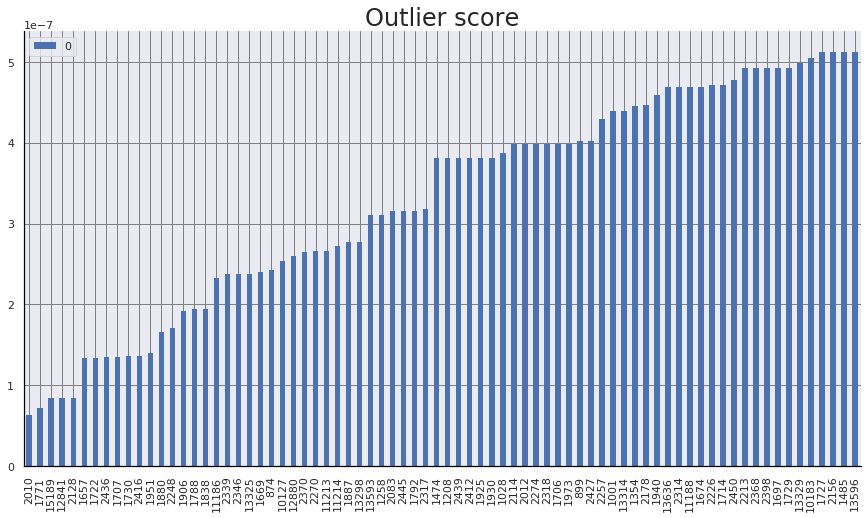

In [85]:
'''Se toma el 0.5% de datos mas raros dados por el score, estos seran los que consideraremos outliers'''
m = int(data.shape[0]*0.005)

fig, ax = plt.subplots(figsize=[15,8])

scores = pd.DataFrame(data = knn_density_est, index = data.index)
scores.sort_values(by=0, inplace=True)

plt.title('Outlier score', fontsize=24)
scores[:m].plot.bar(ax = ax)
plt.show()

In [86]:
data=df.Numericas

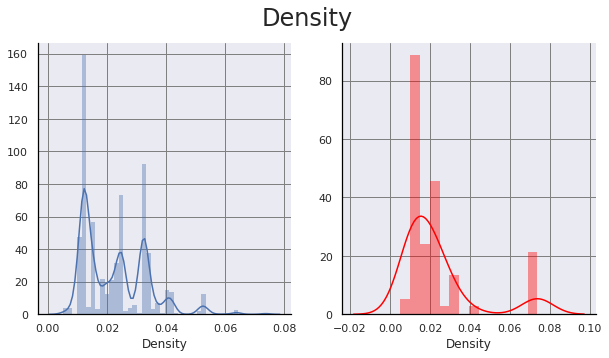

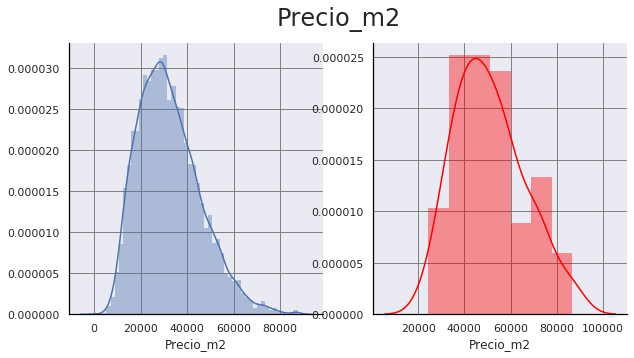

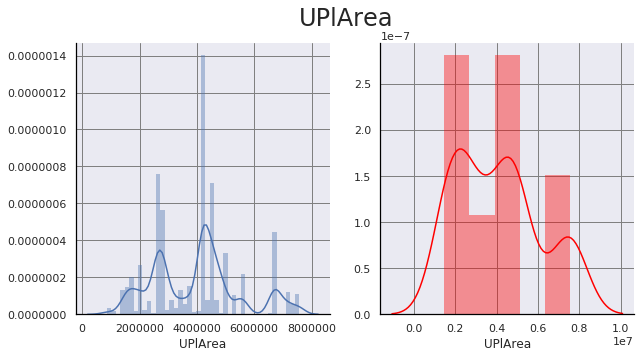

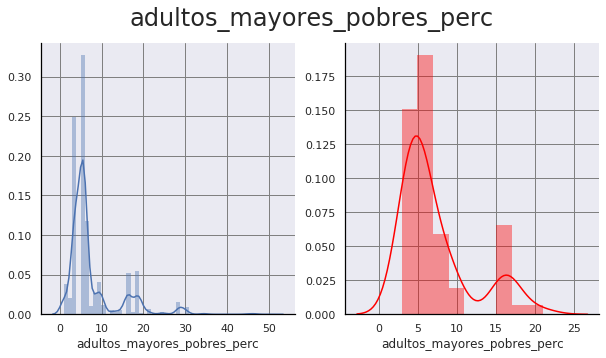

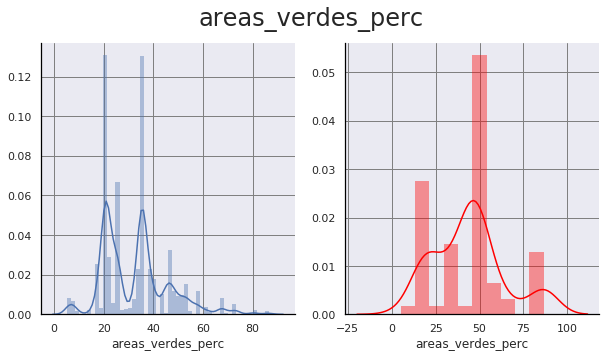

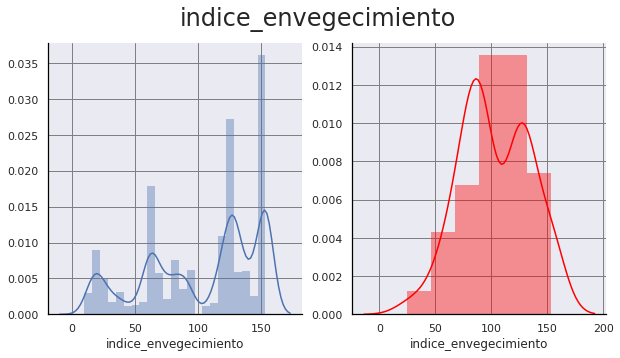

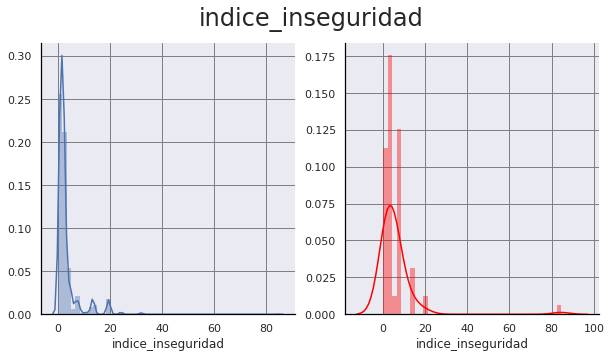

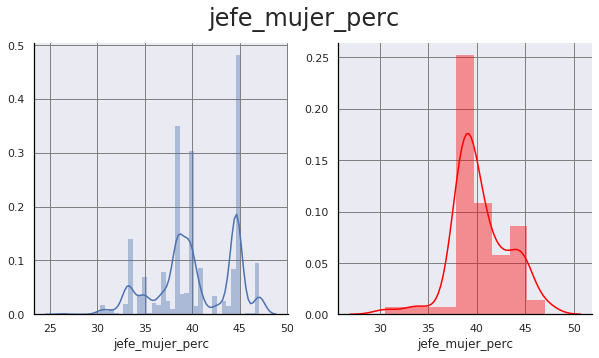

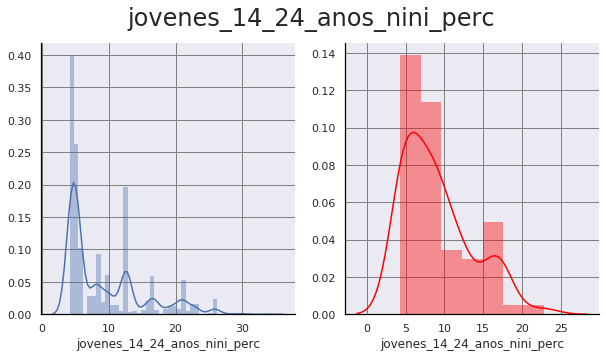

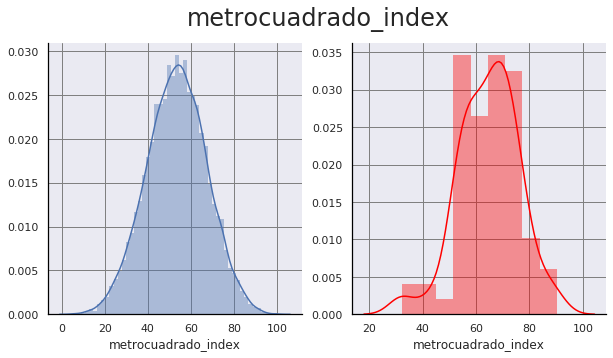

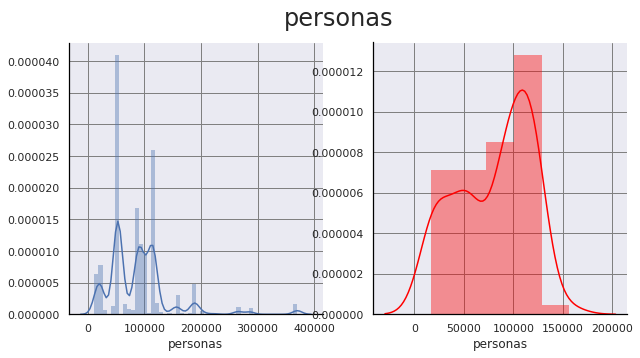

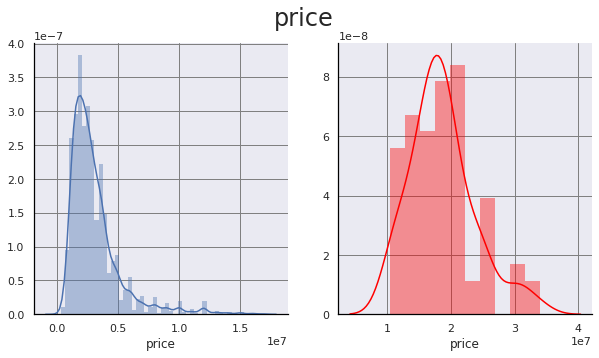

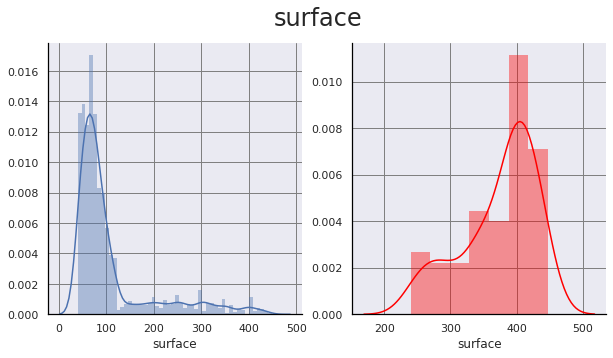

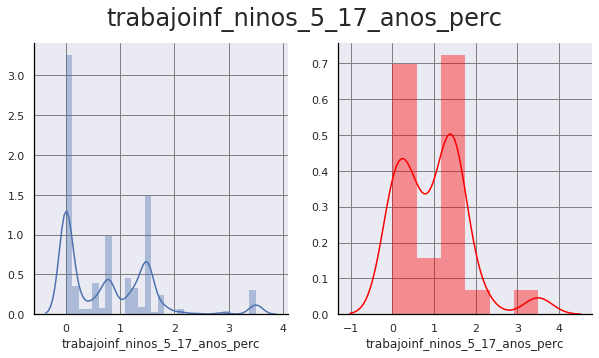

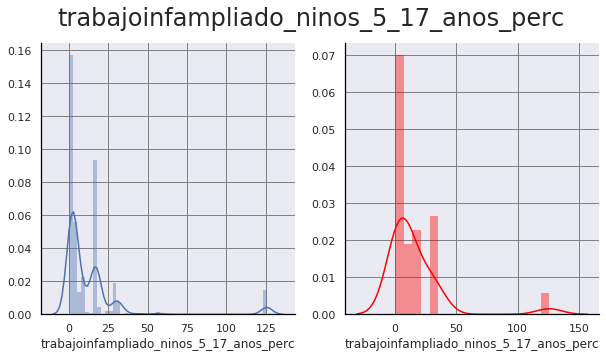

In [87]:
index_out = scores[:m].index
index_in = data.index.difference(index_out)

for col in data.columns:
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle(col, fontsize=24)

    sns.distplot(data.loc[index_in][col], ax=ax[0])
    sns.distplot(data.loc[index_out][col], ax=ax[1], color='red')

    fig.show()

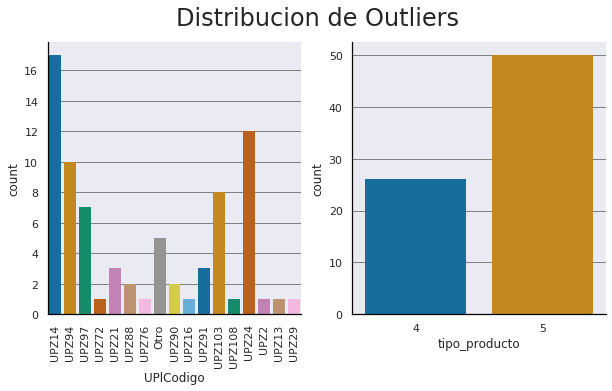

In [92]:
index_out = scores[:m].index
index_in = data.index.difference(index_out)

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Distribucion de Outliers', fontsize=24)

sns.countplot(df.Categoricas.loc[index_out]['UPlCodigo'], ax=ax[0], palette='colorblind')
ax[0].xaxis.set_tick_params(rotation=90)
sns.countplot(df.Ordinales.loc[index_out]['tipo_producto'], ax=ax[1], palette='colorblind')
fig.savefig('./fig/dist_outliers.pdf', bbox_inches='tight')

7. En función del análisis realizado a lo largo de esta pregunta, proponga una selección de variables que permita estimar la variable respuesta por medio de un modelo de regresión, discuta.

In [93]:
'''
Se cargan datos llenados que se agruparon los codigos en UPlClusters segun los resultados de 
la parte 4 (3 grupos):
Cluster 1: Obs con codigo UPZ16
Cluster 2: Obs con codigo UPZ97
Cluster 0: Todos los demas + Otro
Se seleccionan variables de interes para estimar la variable de respuesta
'''
df=pd.read_pickle('./data/data_cluster.pkl')
col_interes = ['Archivo', 'property_type', 
               
               'Numero_Garajes', 'n_bath', 'n_rooms', 'tipo_producto', 'UPlCluster'
               
               'Density', 'indice_envegecimiento','jefe_mujer_perc', 
               'metrocuadrado_index', 'Precio_m2', 'trabajoinf_ninos_5_17_anos_perc']
idxs = indexer(col_interes)
df=df[idxs]
df.head()
df.to_pickle('./data/data_final.pkl')

## P3. Regresión lineal bayesiana
Una vez analizado el conjunto de datos, se procede a modelar las relaciones por medio de alguna herramienta matemática. En este contexto y con las herramientas computacionales entregadas por el curso, se desarrolla un modelo de regresión lineal bayesiana, tratando el problema de modelación desde el punto vista teórico hasta su implementación e interpretación de resultados.

#### Implementación
1. Implemente la clase `RegresionBayesianaEmpirica` que herede de `BaseEstimator` y de `RegressorMixin` del módulo `sklearn.base` en la cual se implementa la heurística enunciada en la sección anterior para aproximar los hiperparámetros óptimos $\alpha$ y $\beta$. Esta clase sólo debe usar objetos de la librería `NumPy` y debe incluir al menos los siguientes métodos:
    * `__init__(self, alpha 0, beta 0, tol=1e-5, maxiter=200)`: sus argumentos son auto explicativos.
    * `get_posteriori(self, X, y, alpha, beta)`: que reciba la matriz de observaciones (`X`), el vector de etiquetas (`y`) y los hiperparámetros $\alpha$ y $\beta$. Este debe retornar los objetos necesarios para interactuar con los demás métodos.
    * `fit(self, X, y)`: que reciba la matriz de observaciones (`X`), el vector de etiquetas (`y`) e implemente el esquema de aproximación mencionado. Este método debe guardar como atributos del objeto los parámetros óptimos obtenidos, además de reportar en pantalla indicadores del proceso iterativo (incluya al menos el número de iteraciones).
    * `predict(self, X , return std=False)`: que reciba una matriz de observaciones (`X_`). Debe retornar la tupla (`y_` , `y_std`) con el vector de medias y el de desviaciones estándar (cuando `return std=True`) asociadas a las observaciones en `X`. Para esto, observe que el proceso de predicción corresponde a asignar la media posterior predictiva del modelo a nuevos puntos.
    
   Note que todo desarrollo sólo necesita de un modelo lineal en los parámetros $w$. Es decir, es posible reemplazar $X$ por una transformación (posiblemente no lineal) $\Phi(X)$, manteniendo la misma estructura distrubucional tanto en predicción como en obtención de hiperparámetros.

In [6]:
from sklearn.base import BaseEstimator,RegressorMixin

class RegresionBayesianaEmpirica(BaseEstimator,RegressorMixin):
    def __init__(self,alpha_0,beta_0,tol=1e-5,maxiter=200):
        ''' Parametros del Modelo '''
        self.alpha_0 = alpha_0
        self.beta_0 = beta_0
        self.tol = tol
        self.maxiter = maxiter
    
    
    def get_posteriori(self,X,y,alpha,beta):
        ''' Parametros de la distribucion '''
        N,d = X.shape
        SN_inv = alpha*np.identity(d) + beta*(X.T@X)
        SN = np.linalg.inv(SN_inv)
        mN = beta*(SN@X.T@y)
        return mN,SN
              
    def fit(self,X,y):
        ''' Parametros iniciales '''
        N,d = X.shape
        iteraciones = self.maxiter
        tolerancia = self.tol
        i=1
        while i<iteraciones+1:
            print('Iteracion '+str(i))
            
            ''' Paramatros iniciales de la iteracion '''
            alfa_inicial = self.alpha_0
            beta_inicial = self.beta_0
            mN,SN = self.get_posteriori(X,y,alfa_inicial,beta_inicial)
            
            ''' Calculamos los valores propios y los vectores propios'''
            lamb,vect = np.linalg.eig(beta_inicial*(X.T@X))
            lamb = np.real_if_close(lamb,tol = 1)
            
            gamma =(lamb/(alfa_inicial + lamb)).sum()
            
            ''' Posibles Nuevos valores'''
            alpha = gamma/(mN.T@mN)
            beta = (N-gamma)/(((y-mN.T@X.T)**2).sum())
            
            '''Verificar si son casi iguales '''
            error_alpha = abs(alpha - alfa_inicial)
            error_beta = abs(beta - beta_inicial )
            print('alpha: ',alpha,'    beta: ',beta)
            if i%10 ==0:
                print('Error Alpha: ',error_alpha,'   Error Beta: ',error_beta)
            if error_alpha <tolerancia and error_beta < tolerancia:
                ''' Guardamos los parametros encontrados '''
                self.alpha_0 = alpha
                self.beta_0 = beta
                break
            else:
                self.alpha_0 = alpha
                self.beta_0 = beta
                i = i+1
                print('\n')
        self.mN,self.SN = self.get_posteriori(X,y,alpha,beta)
        ''' Reporte del Resultado Final'''
        print('\n')
        print('Resultados Finales')
        print('alpha final = ',alpha)
        print('beta final = ',beta)
            
            
    def predict(self,X_,return_std=False):
        ''' Generamos el vector de medias y el de desviaciones estándar '''
        y_ = X_ @ self.mN
        y_std = 1/self.beta_0 + np.diag((X_ @ self.SN)@X_.T)
        if return_std == False:
            return y_
        if return_std == True:
            return (y_,y_std)
    

En las siguientes preguntas se construye un modelo de regresion en el cual debe incluir todas las variables disponibles en el conjunto de datos, reemplazando la variable de UPZ por la recategorizacion antes propuesta.

2. Construya un fujo de transformaciones sobre el conjunto datos. Por medio de la clase `Pipeline` debería:
    * Utilizar `StandardScaler` y `OneHotEncoder` donde corresponda.
    * Utilizar el objeto `PolynomialFeatures` para generar características polinomiales, en este apartado, se recomienda utilizar características de grado 3 sólo en las variables numéricas y luego concatenar con las codificaciones categóricas.
    * Generar una composición de transformaciones por medio de `ColumnTransformer`.

In [7]:
''' Importamos lo necesario para transformar los datos '''
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder,PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

''' Llamamos al df con las columnas reducidas '''
df_P3 = pd.read_pickle('./data/data_cluster.pkl')

''' Separamos los datos en X e y'''
df_y = df_P3.Numericas['Precio_m2']#.to_numpy()
df_X = df_P3.drop([('Numericas','Precio_m2'),('Numericas','price'),('Numericas','surface'),
                    ('Numericas','personas'),('Numericas','UPlArea'),('Categoricas','property_type')],axis=1)

''' Filtramos las filas por tipo de datos'''
num_cols = df_X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df_X.select_dtypes(include=['object']).columns

''' Pipeline para las variables categoricas '''
cat_pipe = Pipeline([('ordinal', OneHotEncoder(handle_unknown='ignore'))])

''' Pipeline para las variables Numericas'''
num_pipe = Pipeline([('scaler',StandardScaler()),('poly',PolynomialFeatures(degree = 3))])

''' Juntamos lo anterior '''
prep = ColumnTransformer(transformers = [('num',num_pipe,num_cols),('cat',cat_pipe,cat_cols)])

3. Expanda el `Pipeline` anterior agregando el modelo representado en la clase `RegresionBayesianaEmpirica`. Genere una separación de entrenamiento y test por medio de `train_test_split` del módulo `model_selection` donde el 20% de los datos sea de test. Entrene su modelo utilizando el método .fit como parámetros dentro del flujo creado por medio de Pipeline, evalúe su modelo por medio de la raíz del promedio de errores cuadráticos (_Root Mean Square Error - RMSE_. en inglés) en el conjunto de test, incluya el estadístico $R^2$.\
__Hint__: pruebe con valores para `alpha_0` y `beta_0` entre $10^{-10}$ y $10^{-5}$. Compruebe que dichos dichos hiperparametros son adecuados, al obtener un $R^2$ cercano a $0.7$.

In [8]:
from sklearn.model_selection import train_test_split

def run_pipeline(df_X,df_Y,pipeline):
    ''' Separamos el data set en datos de entrenamiento y datos de testeo'''
    X_train,X_test,y_train,y_test = train_test_split(df_X,df_y,test_size=0.2,random_state = 31)
    
    ''' Fiteamos los datos a traves del pipeline'''
    pipeline.fit(X_train,y_train)
    
    ''' Predecimos el valor de los valores de testeo '''
    y_pred = pipeline.predict(X_test)
    
    ''' Valores que sirven para ver que tan buena fue la prediccion '''
    R2 = pipeline.score(X_test,y_test)
    RMSE = np.sqrt(np.mean((y_test-y_pred)**2))
    return pipeline,R2,RMSE

''' Funcion para mostrar dos tablas a la vez '''
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [39]:
''' Se generan las grillas para alpha y beta iniciales '''
''' En este caso solo lo haremos con 4 valores porque se demora bastante en cada iteracion'''
grilla_alpha = np.linspace(2e-10,1e-5,num=1,endpoint=False)
grilla_beta = np.linspace(2e-10,1e-5,num=1,endpoint=False)

''' Listas con los valores deseados'''
valores = []
valores_R2 = []
valores_pipe = []
valores_RMSE = []

''' Iteramos con los alphas y betas'''
for alpha in grilla_alpha:
    for beta in grilla_beta:
        print('Alpha Inicial: ',alpha,'   Beta Inicial: ',beta)
        Pipe_Transformaciones = Pipeline([('prep',prep),('classifier',RegresionBayesianaEmpirica(alpha,beta,tol=1e-10,maxiter=30))])
        Pipe,R2, RMS2 = run_pipeline(df_X,df_y,Pipe_Transformaciones)
        
        ''' Guardamos los parametros '''
        valores_R2.append(R2)
        valores.append([alpha,beta])
        valores_pipe.append(Pipe)
        valores_RMSE.append(RMS2)
        
        ''' Limpiamos los output obtenidos '''
        clear_output(wait=True)

''' Los parametros obtenidos en el alpha y beta optimos '''
optimo = valores[valores_R2.index(max(valores_R2))]
Pipe_opt = valores_pipe[valores_R2.index(max(valores_R2))]
R2 = valores_R2[valores_R2.index(max(valores_R2))]
RMSE = valores_RMSE[valores_R2.index(max(valores_R2))]
alpha = Pipe_opt.get_params(deep=False)['steps'][1][1].get_params()['alpha_0']
beta = Pipe_opt.get_params(deep=False)['steps'][1][1].get_params()['beta_0']

''' Mostramos la informacion importante '''
alpha_beta = pd.DataFrame([[optimo[0],optimo[1]],[alpha,beta]],index = ['Inicial','Final'],columns = ['Alpha',' Beta'])
Parametros = pd.DataFrame([R2,RMSE],index = ['R2',' RMSE'],columns = ['Errores'])
display_side_by_side(alpha_beta,Parametros.round(3))

Alpha 
 Beta 
 
 
 
 
 Inicial 
 7.000060e-06 
 2.000000e-10 
 
 
 Final 
 9.974670e-07 
 1.770767e-08 
 
 
 
 
 
 
 Errores 
 
 
 
 
 R2 
 0.685 
 
 
 RMSE 
 7482.755

4. Utilice su selección de variables, transfórmelas adaptando el esquema de preprocesamiento anterior, separe en conjuntos de entrenamiento y test manteniendo el 20% de proporción y evalúe los resultados del modelo `RegresionBayesianaEmpirica` incluyendo el estadístico $R^2$. Discuta.

In [9]:
''' Llamamos al df con las columnas reducidas '''
df_P4 = pd.read_pickle('./data/data_final.pkl')

''' Separamos los datos en X e y'''
df_y = df_P4.Numericas['Precio_m2']#.to_numpy()
df_X = df_P4.drop(('Numericas','Precio_m2'),axis=1)

''' Filtramos las filas por tipo de datos'''
num_cols = df_X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df_X.select_dtypes(include=['object']).columns

''' Pipeline para las variables categoricas'''
cat_pipe = Pipeline([('ordinal', OneHotEncoder(handle_unknown='ignore'))])

''' Pipeline para las variables numericas'''
num_pipe = Pipeline([('scaler',StandardScaler()),('poly',PolynomialFeatures(degree = 3))])

prep = ColumnTransformer(transformers = [('num',num_pipe,num_cols),('cat',cat_pipe,cat_cols)])

In [10]:
''' Se generan las grillas para alpha y beta iniciales '''
grilla_alpha = np.linspace(2e-10,1e-5,num=10,endpoint=False)
grilla_beta = np.linspace(2e-10,1e-5,num=10,endpoint=False)

''' Listas con los valores deseados'''
valores = []
valores_R2 = []
valores_pipe = []
valores_RMSE = []

''' Iteramos con los alphas y betas'''
for alpha in grilla_alpha:
    for beta in grilla_beta:
        print('Alpha Inicial: ',alpha,'   Beta Inicial: ',beta)
        Pipe_Transformaciones = Pipeline([('prep',prep),('classifier',RegresionBayesianaEmpirica(alpha,beta,tol=1e-15))])
        Pipe,R2, RMS2 = run_pipeline(df_X,df_y,Pipe_Transformaciones)
        
        ''' Guardamos los parametros '''
        valores_R2.append(R2)
        valores.append([alpha,beta])
        valores_pipe.append(Pipe)
        valores_RMSE.append(RMS2)
        
        ''' Limpiamos los output obtenidos '''
        clear_output(wait=True)

''' Los parametros obtenidos en el alpha y beta optimos '''
optimo = valores[valores_R2.index(max(valores_R2))]
Pipe_opt = valores_pipe[valores_R2.index(max(valores_R2))]
R2 = valores_R2[valores_R2.index(max(valores_R2))]
RMSE = valores_RMSE[valores_R2.index(max(valores_R2))]
alpha = Pipe_opt.get_params(deep=False)['steps'][1][1].get_params()['alpha_0']
beta = Pipe_opt.get_params(deep=False)['steps'][1][1].get_params()['beta_0']

''' Mostramos la informacion importante '''
alpha_beta = pd.DataFrame([[optimo[0],optimo[1]],[alpha,beta]],index = ['Inicial','Final'],columns = ['Alpha',' Beta'])
Parametros = pd.DataFrame([R2,RMSE],index = ['R2',' RMSE'],columns = ['Errores'])
display_side_by_side(alpha_beta,Parametros.round(3))

Alpha 
 Beta 
 
 
 
 
 Inicial 
 5.000100e-06 
 2.000000e-10 
 
 
 Final 
 2.610944e-07 
 1.597317e-08 
 
 
 
 
 
 
 Errores 
 
 
 
 
 R2 
 0.663 
 
 
 RMSE 
 7732.169

In [13]:
import pickle
''' Guardamos el Modelo'''
filename = "modelo.pkl"
X_train,X_test,y_train,y_test = train_test_split(df_X,df_y,test_size=0.2,random_state = 31)
pickle.dump(Pipe_opt,open(filename,'wb'))

''' Probamos que se guardo bien el modelo '''
loaded_model = pickle.load(open(filename,'rb'))
result = loaded_model.score(X_test,y_test)
print(result == R2)

True


5. Finalmente, compare los resultados de su selección de variables con los obtenidos por un pipeline donde el estimador sea uno de la clase `BayesianRidge` del módulo `sklearn.linear_model`. Discuta la diferencia de este módulo con respecto al desarrollado por ustedes.

In [99]:
from sklearn.linear_model import BayesianRidge

Pipe_Ridge= Pipeline([('prep',prep),('classifier',BayesianRidge())])
cosa,R2,RMSE = run_pipeline(df_X,df_y,Pipe_Ridge)

In [100]:
pd.DataFrame([R2,RMSE],index = ['R2','RMSE'],columns = ['Errores'])

,Errores
R2,0.663450
RMSE,7728.369268
